# Conversationnal Agent

**Our model : **

![Model](figs/Model.png)

In [1]:
from __future__ import unicode_literals, print_function, division
import os
from io import open
import unicodedata
import string
import re
import random
# package a installer d'abord avec anaconda
#import spacy

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# package a installer d'abord avec anaconda
import gensim
from gensim.models import KeyedVectors

#import nltk
#nltk.download()
#from nltk.tokenize import sent_tokenize, word_tokenize

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import unidecode
from unidecode import unidecode

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import time
import math
import re
import json

In [3]:
use_cuda = False
print(torch.cuda.is_available())
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

True


In [4]:
Generation = True # False pour du sélectif, True pour du génératif

# 1 Training data preparation

### 1.1 Simple formatting of training dialogues

Dialogue formatting for training :

1. Removal of stopwords (stopwords : none)
3. Remove line numbers whether necessary (for dialogue bAbI tasks)
4. Turns encoding from Unicode to ASCII
5. Insertion of variable words (for Master's program dataset)

In [5]:
# -------------------- enlèvement des stopwords ---------------------------------------
def TrimWordsSentence(sentence, stopwords):
    '''Remove stopwords from a sentence'''
    resultwords = [word for word in sentence.split() if word.lower() not in stopwords]
    resultwords = ' '.join(resultwords)
    return resultwords

def TrimWordsDialogue(dialogue, stopwords):
    '''Remove stopwords from user utterances in a dialogue'''
    for pair in dialogue: 
        pair[0] = TrimWordsSentence(pair[0], stopwords)
        #pair[1] = pair[1].strip()
    return dialogue

def TrimWords(dialogues, stopwords):
    '''Remove stopwords from user utterances in a list of dialogues'''
    return [TrimWordsDialogue(dialogue, stopwords) for dialogue in dialogues ]

    
#-------------------------- Enleve les numéros en début de ligne -------------------
def enleveNumero(s):
    '''Remove line numbers in dialogue bAbI tasks dataset'''
    spl = s.split(' ')
    if spl[0].isdigit():
        spl = spl[1:] 
    return ' '.join(spl)


# --------------------------- Normalisation -------------------------------
def unicodeToAscii(s):
    """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    '''Remove rare symbols from a string'''
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9?&\%\-\_]+", r" ", s) 
    return s 



#--------------------- import des dialogues --------------------
def importDialogues(fichier, limite = None):
    '''Import a textfile containing dialogues and returns a list, each element 
       corresponding to a dialogue and also being under the form of a list, with 
       each element being a list of two elements : an element giving a user 
       utterance and another element giving the bot response. Both elements are 
       normalized strings.
       Ex. The dialogue :
       
               hi    hello what can i help you with today
               can you book a table    i m on it
               
       now becomes :
       
              [['hi', 'hello what can i help you with today'], 
               ['can you book a table', 'i m on it']]
               
       Lines corresponding to user utterance with no bot response are discarted.
    '''
    dialogues_import = open(fichier, encoding='utf-8').read().strip().split('\n\n')
    dialogues = []
    for i, d in enumerate(dialogues_import):
        dialogue = []
        lines = d.split('\n')
        for l in lines:
            if len(l.split('\t')) == 2 :
                pair = [normalizeString(s) for s in l.split('\t')]
                pair[0] = enleveNumero(pair[0])
                dialogue.append(pair)
        dialogues.append(dialogue)
        if limite is not None and i == limite -1 :
            break

    return dialogues


def importVraisDialogues(fichier, limite = None):
    '''Applies to the dialogue bAbI tasks dataset. Import a textfile containing 
       dialogues in the form of a list, each element corresponding to a dialogue 
       and also being under the form of a list, with each element being a list 
       containing an element containing the user utterance and, whenever existant, 
       another element containing the bot response. All elements are normalized 
       strings.
       Ex. The dialogue :
       
               hi    hello what can i help you with today
               can you book a table    i m on it
               
       now becomes :
       
              [['hi', 'hello what can i help you with today'], 
               ['can you book a table', 'i m on it']]
    '''
    dialogues_import = open(fichier, encoding='utf-8').read().strip().split('\n\n')
    dialogues = []
    for i, d in enumerate(dialogues_import):
        dialogue = []
        lines = d.split('\n')
        for l in lines:
            if len(l.split('\t')) == 1 :
                pair0 = normalizeString(l)
                pair0 = enleveNumero(pair0)
                pair = [pair0, '' ]
                dialogue.append(pair)
            elif len(l.split('\t')) == 2 :
                pair = [normalizeString(s) for s in l.split('\t')]
                pair[0] = enleveNumero(pair[0])
                dialogue.append(pair)
        dialogues.append(dialogue)
        if limite is not None and i == limite -1 :
            break

    return dialogues



def importBabiTasks(fichier, limite = None):
    '''Applies to the bAbI tasks dataset. Import a textfile containing short texts
       in the form of a list, each element corresponding to a text and also being 
       under the form of a list, with each element containing an utterance of the text. 
       All elements are normalized strings.
       Ex. The text :
       
                The triangle is above the pink rectangle.
                The blue square is to the left of the triangle.
               
       now becomes :
       
              ['the triangle is above the pink rectangle', 
               'the blue square is to the left of the triangle']
    '''
    lines_import = open(fichier, encoding='utf-8').read().strip().split('\n')
    sortie = []
    text = []
    for i, line in enumerate(lines_import):
        sline= line.split('\t')
        if len(sline) == 1 :
            l = normalizeString(sline[0])
            l = enleveNumero(l)
            text.append(l)
        else :
            l = [normalizeString(el) for el in sline[ :2]]
            qa = [enleveNumero(el) for el in l]
            text_with_qa = text + qa
            sortie.append(text_with_qa)
            
        next_line_number = lines_import[i+1].split(' ')[0] if i < len(lines_import)-1 else '0'
        if next_line_number == '1' :
            text = []
                
    return sortie



# --------------------- Insertion des mots variables---------------------------
def modify(dialogues) :
    '''Applies to the dialogue bAbI tasks dataset. Formatting function 
       replacing all restaurant names, phone and address by one of the 
       three tokens 'option_name', 'option_phone' and 'option_address'.
    '''
    copie = list(dialogues)
    for dialogue in copie :
        optNum = 0
        for i in range(len(dialogue)) :
            utterance = dialogue[i][1]
            if utterance.startswith('what do you think of this option') :
                optNum += 1
                utterance = 'what do you think of this option ' + 'option' + str(optNum) + '_name'
            elif utterance.startswith('here it is') and utterance.endswith('phone') :
                utterance = 'here it is ' + 'option' + str(optNum) + '_phone'
            elif utterance.startswith('here it is') and utterance.endswith('address') :
                utterance = 'here it is ' + 'option' + str(optNum) + '_address'
            dialogue[i][1] = utterance
    return copie

#------------------ Dictionnaire des mots variables -----------------------------
def motVar(file):
    '''Applies to the Master's program dataset.
       Import the collection of pairs token-content for a set of variable words.
    '''
    lines = open(file, encoding='utf-8').read().strip().split('\n')
    motsVar = {}
    for l in lines :
        cle, valeur = l.split('\t')
        motsVar[cle.lower()] = valeur
    return motsVar


def ReplaceMotVar(motsVar, list_of_string):
    sentence = []
    for word in list_of_string :
        if word in motsVar.keys() :
            sentence.append(motsVar[word])
        else :
            sentence.append(word)
    return sentence


# ----------------------- Création de la liste des dialogues--------------------
def prepareData(opt):
    '''Import dialogue from text file and apply some formatting operations,
       as described in the functions 
               - importDialogues
               - modify
               - TrimWords
               - filterDialogues
    '''
    dialogues = importDialogues(fichier = opt['fichier'], 
                                limite = opt['limite'])
    dialogues = modify(dialogues) if opt['modify'] else dialogues
    dialogues = TrimWords(dialogues, opt['stopwords']) # on enlève les stopwords de chaque question
    print(" %s dialogues ..." % len(dialogues))
    print(dialogues[0])
    if opt['filtre'] :
        #for pair in [pair for pair in pairs if not filterPair(pair)]:
        #    print('%s (%d) -> %s (%d)' % (pair[0],len(pair[0].split()),pair[1],len(pair[1].split())))  
        dialogues = filterDialogues(dialogues, opt['max_length'])
        print('')
        print("... reduced to %s dialogues" % len(dialogues))

    return dialogues


def prepareVraieData(opt):
    '''Applies to the dialogue bAbI tasks dataset. Import dialogue from text 
       file and apply some formatting operations, as described in the functions 
               - importVraisDialogues
               - modify
               - TrimWords
               - filterDialogues
    '''
    dialogues = importVraisDialogues(opt['fichier'])
    dialogues = modify(dialogues) if opt['modify'] else dialogues
    dialogues = TrimWords(dialogues, opt['stopwords']) # on enlève les stopwords de chaque question
    print(" %s dialogues ..." % len(dialogues))
    print(dialogues[0])
    if opt['filtre'] :
        #for pair in [pair for pair in pairs if not filterPair(pair)]:
        #    print('%s (%d) -> %s (%d)' % (pair[0],len(pair[0].split()),pair[1],len(pair[1].split())))  
        dialogues = filterDialogues(dialogues, opt['max_length'])
        print('')
        print("... reduced to %s dialogues" % len(dialogues))

    return dialogues

In [6]:
motsVar = motVar('C:data/chatbot-M2-DS-Variables.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'C:data/chatbot-M2-DS-Variables.txt'

### 1.2 Language class

In [ ]:
SOS_token = 0
EOS_token = 1
UNK_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"} if Generation else {}
        self.n_words = 3 if Generation else 0  # Counts SOS and EOS and UNK

        
    def addWord(self, word):
        '''Add a word to the language'''
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
    def addSentence(self, sentence):
        '''Add to the language all words of a sentence'''
        for word in sentence.split():
            self.addWord(word)
            
            
    def addDialogues(self, dialogues, i):
        '''Add to the language all words contained into : either all user utterances 
          (if i = 0) or all bot utterances (if i = 1), of a list of dialogues'''
        for dialogue in dialogues :
            for pair in dialogue:
                try :
                    self.addSentence(pair[i])
                except IndexError:
                    print("Problem with {}".format(pair))

In [ ]:
def generateLanguages(dialogues):
    '''Generate three languages classes out of a list of dialogues :
            - input_lang containing the user's vocabulary
            - output lang containing the bot vocabulary
            - output_sentence_lang containing the bot answers as words of a vocabulary
    '''
    input_lang = Lang('questions')
    output_lang = Lang('answers')
    output_sentences_lang = Lang('sentences')
    
    input_lang.addDialogues(dialogues, 0)
    output_lang.addDialogues(dialogues, 1)
    for dialogue in dialogues :
        for pair in dialogue:
            output_sentences_lang.addWord(pair[1])
    print("Mots comptés :")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    print(output_sentences_lang.name, output_sentences_lang.n_words)
    
    return input_lang, output_lang, output_sentences_lang


def ajout(dialogues, lang, i= 1):
    '''addDialogues method of the Lang class with prints.'''
    lang.addDialogues(dialogues, i)
    print(lang.name, lang.n_words)
    return lang 


def ajoutSentences(dialogues, sentences_lang, i = 1) :
    '''Add sentences as words to a given language'''
    for dialogue in dialogues :
        for pair in dialogue :
            try :
                sentences_lang.addWord(pair[i])
            except IndexError:
                print("Problem with {}".format(pair))
                
    return sentences_lang

### 1.3 Turn dialogues from text to one hot variables



In [ ]:
# ----------------- Remplacement des mots par leurs indices  ---------------------

def indexesFromSentence(lang, sentence, max_length = None, rand = 0):
    '''Turn a given sentence into a list of indices according to a given language'''
    indexes=[]
    unknowns = 0
    words = sentence.split(' ')
    for word in words:
        p = random.random()
        if word not in set(lang.word2index) :
            indexes.append(UNK_token)
        elif p >= rand :
            indexes.append(lang.word2index[word])
        elif p < rand :
            e = random.choice([1, 2, 3])
            if e == 1 : # doesn't put any word
                pass
            elif e== 2 :# hide word with UNK_Token
                indexes.append(UNK_token)
            else :      # put word followed with randomly selected other word
                indexes.append(lang.word2index[word])
                indexes.append(random.choice(list(range(lang.n_words))))


    # remove exceeding words, exept first word and the two last words or symbols
    if max_length is not None :
        print(max_length)
        while len(indexes) > max_length:
            indexes.pop(random.randint(1,len(indexes)-2))
    return indexes


def variableFromSentence(lang, sentence, max_length = None, rand = 0):
    '''Turn a sentence into a torch variable, containing a list of indices according
       to a given language.
    '''
    indexes = indexesFromSentence(lang, sentence, max_length, rand) # turn string into list of indices
    indexes.append(EOS_token)                                 # append EOS_token index
    result = Variable(torch.LongTensor(indexes).view(-1, 1))  # wrap the list into torch variable
    return result


def selectedVariableFromSentence(lang, sentence):
    '''Turn a sentence into a torch variable, containing the index of this sentence
       according to a given language.
    '''
    index = []
    index.append(lang.word2index[sentence])
    result = Variable(torch.LongTensor(index).view(-1, 1))
    return result


def variablesFromDialogue(input_lang, output_lang, dialogue, max_length = None, rand = 0):
    '''Turn a whole dialogue into a list of torch tensors, according to an input
       and an output languages'''
    sortie = []
    for pair in dialogue :
        input_variable = variableFromSentence(input_lang, pair[0], max_length, rand)
        target_variable = variableFromSentence(output_lang, pair[1], max_length, rand)
        sortie.append((input_variable, target_variable))
    return sortie



# ----------------- Récupérer une phrase a partir des indices ---------------------
def SentenceFromIndexes(input_lang, indexes):
    '''Turn a list of indices into a sentence according to a given language.'''
    sentence = []
    for i in indexes:
        sentence.append(input_lang.index2word[i])
    sentence = ' '.join(sentence)
    return sentence

# 2 Embedding and word tagging

### 2.0 Regex

In [ ]:
# --------------------------- Normalisation -------------------------------
def unicodeToAscii(s):
    """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# see https://docs.python.org/3/library/re.html
def normalizeString(s):
    '''Remove rare symbols from a string'''
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9?&\%\_]+", r" ", s) # 'r' before a string is for 'raw' # try removing \-
    return s 

### 2.1 Pre-trained word embedding

In [ ]:
#taken from https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

In [ ]:
# equivalent of numpy for very large arrays (such as a database of pretrained word vectors)
# optimized for SQL-like operations, not for math computations
# see https://bcolz.readthedocs.io/en/latest/intro.html

# installer avec la commande : conda install bcolz
import bcolz

In [ ]:
import pickle

In [ ]:
glove_path = 'data/GloVe'

In [ ]:
words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.50.dat', mode='w')

In [ ]:
with open(f'{glove_path}/glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)

In [ ]:
vectors.shape

In [ ]:
vectors = bcolz.carray(vectors[1:].reshape((400000, 50)), rootdir=f'{glove_path}/6B.50.dat', mode='w')
vectors.flush()

In [ ]:
pickle.dump(words, open(f'{glove_path}/6B.50_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{glove_path}/6B.50_idx.pkl', 'wb'))

In [ ]:
vectors = bcolz.open(f'{glove_path}/6B.50.dat')[:]
words = pickle.load(open(f'{glove_path}/6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{glove_path}/6B.50_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [ ]:
len(glove)

Load state_dict into a Pytorch Embedding layer

In [ ]:
class Encoder_biGRU(nn.Module):
    '''Module performing reading of a sentence, and returns :
    
            - embedding vector of each word
            - hidden vector of each word
            - the last two hidden states of the bi-GRU module
    '''
    def __init__(self, 
                 input_lang_size, 
                 embedding_dim, 
                 hidden_dim, 
                 pre_entrainement = None, 
                 freeze = False, 
                 tag = False, 
                 n_layers=1
                ): 
        super(Encoder_biGRU, self).__init__()
        
        # relevant quantities
        self.bi_gru = True
        self.input_lang_size = input_lang_size # size of word vocabulary
        self.embedding_dim = embedding_dim     # dimension of embedded words
        self.output_dim = hidden_dim * 2       # dimension of contextual rep. of words and utterance
        self.hidden_dim = hidden_dim           # dimension of hidden state of GRUs
        self.tag = tag
        self.n_layers = n_layers

        
        # embedding module, performing both one-hot encoding and embedding of a word index
        self.embedding = nn.Embedding(input_lang_size, embedding_dim)
        
        
        if pre_entrainement is not None :
            self.embedding.weight = nn.Parameter(torch.Tensor(pre_entrainement))
        # ou bien    
        self.embedding.load_state_dict({'weight': pre_entrainement})
        
        
        if freeze :
            self.embedding.weight.requires_grad = False
        
        # bidirectionnal GRU module
        if tag :
            # TODO
            self.tag_dim = tag_dim
            self.embedding_tag = nn.Embedding(tag_dim, tag_dim)
            self.embedding_tag.weight = nn.Parameter(torch.eye(tag_dim))
            self.gru = nn.GRU(embedding_dim + tag_dim, hidden_dim)
            self.gru2 = nn.GRU(embedding_dim + tag_dim, hidden_dim)
        else :
            self.gru = nn.GRU(embedding_dim, hidden_dim)
            self.gru2 = nn.GRU(embedding_dim, hidden_dim)
          
        
    def initHidden(self): 
        result = Variable(torch.zeros(1, 1, self.hidden_dim))
        if use_cuda:
            return result.cuda()
        else:
            return result
 
    def forward(self, utterance, hidden, hidden2):
        '''takes as parameters : 
        
                an utterance as list of indices,            dim = (input_length, 1)
                a state initializing the forward GRU        dim = (1, 1, hidden_dim)
                a state initializing the backward GRU       dim = (1, 1, hidden_dim)
        
           returns the tensors : 
        
                the word embeddings,                        dim = (input_length, 1, embedding_dim)
                the word hidden representations,            dim = (input_length, 2*embedding_dim)
                the last hidden state of the forward GRU    dim = (1, 1, hidden_dim)
                the last hidden state of the backward GRU   dim = (1, 1, hidden_dim)
        '''
        input_length = utterance.size()[0]
        embeddings = self.embedding(utterance)                          # dim = (input_length, 1, embedding_dim)
        hiddens1 = Variable(torch.zeros(input_length, self.hidden_dim)) # dim = (input_length, embedding_dim)
        hiddens2 = Variable(torch.zeros(input_length, self.hidden_dim)) # dim = (input_length, embedding_dim)
        for i in range(input_length):
            k = input_length - 1 - i
            for j in range(self.n_layers):
                word = embeddings[i].view(1, 1, -1)
                output, hidden = self.gru(word, hidden)
                hiddens1[i] = hidden
                word2 = embeddings[k].view(1, 1, -1)
                output2, hidden2 = self.gru2(word2, hidden2)
                hiddens2[k] = hidden2
        hiddens = torch.cat((hiddens1, hiddens2), dim = 1)              # dim = (input_length, 2*embedding_dim)
        return embeddings, hiddens, hidden, hidden2

# 3 Agent modules

### 3.1 Encoder module

We detail the Encoder module integrating a bidirectionnal version of GRU module :

![Encoder](figs/Encoder.png)

In [ ]:
class Encoder_biGRU(nn.Module):
    '''Module performing reading of a sentence, and returns :
    
            - embedding vector of each word
            - hidden vector of each word
            - the last two hidden states of the bi-GRU module
    '''
    def __init__(self, 
                 input_lang_size, 
                 embedding_dim, 
                 hidden_dim, 
                 pre_entrainement = None, 
                 freeze = False, 
                 tag = False, 
                 n_layers=1
                ): 
        super(Encoder_biGRU, self).__init__()
        
        # relevant quantities
        self.bi_gru = True
        self.input_lang_size = input_lang_size # size of word vocabulary
        self.embedding_dim = embedding_dim     # dimension of embedded words
        self.output_dim = hidden_dim * 2       # dimension of contextual rep. of words and utterance
        self.hidden_dim = hidden_dim           # dimension of hidden state of GRUs
        self.tag = tag
        self.n_layers = n_layers

        
        # embedding module, performing both one-hot encoding and embedding of a word index
        self.embedding = nn.Embedding(input_lang_size, embedding_dim)
        if pre_entrainement is not None :
            self.embedding.weight = nn.Parameter(torch.Tensor(pre_entrainement)) 
        if freeze :
            self.embedding.weight.requires_grad = False
        
        # bidirectionnal GRU module
        if tag :
            # TODO
            self.tag_dim = tag_dim
            self.embedding_tag = nn.Embedding(tag_dim, tag_dim)
            self.embedding_tag.weight = nn.Parameter(torch.eye(tag_dim))
            self.gru = nn.GRU(embedding_dim + tag_dim, hidden_dim)
            self.gru2 = nn.GRU(embedding_dim + tag_dim, hidden_dim)
        else :
            self.gru = nn.GRU(embedding_dim, hidden_dim)
            self.gru2 = nn.GRU(embedding_dim, hidden_dim)
          
        
    def initHidden(self): 
        result = Variable(torch.zeros(1, 1, self.hidden_dim))
        if use_cuda:
            return result.cuda()
        else:
            return result
 
    def forward(self, utterance, hidden, hidden2):
        '''takes as parameters : 
        
                an utterance as list of indices,            dim = (input_length, 1)
                a state initializing the forward GRU        dim = (1, 1, hidden_dim)
                a state initializing the backward GRU       dim = (1, 1, hidden_dim)
        
           returns the tensors : 
        
                the word embeddings,                        dim = (input_length, 1, embedding_dim)
                the word hidden representations,            dim = (input_length, 2*embedding_dim)
                the last hidden state of the forward GRU    dim = (1, 1, hidden_dim)
                the last hidden state of the backward GRU   dim = (1, 1, hidden_dim)
        '''
        input_length = utterance.size()[0]
        embeddings = self.embedding(utterance)                          # dim = (input_length, 1, embedding_dim)
        hiddens1 = Variable(torch.zeros(input_length, self.hidden_dim)) # dim = (input_length, embedding_dim)
        hiddens2 = Variable(torch.zeros(input_length, self.hidden_dim)) # dim = (input_length, embedding_dim)
        for i in range(input_length):
            k = input_length - 1 - i
            for j in range(self.n_layers):
                word = embeddings[i].view(1, 1, -1)
                output, hidden = self.gru(word, hidden)
                hiddens1[i] = hidden
                word2 = embeddings[k].view(1, 1, -1)
                output2, hidden2 = self.gru2(word2, hidden2)
                hiddens2[k] = hidden2
        hiddens = torch.cat((hiddens1, hiddens2), dim = 1)              # dim = (input_length, 2*embedding_dim)
        return embeddings, hiddens, hidden, hidden2

Mono-GRU version of the Encoder :

In [ ]:
class Encoder_monoGRU(nn.Module): 

    def __init__(self, 
                 input_lang_size, 
                 embedding_dim, 
                 hidden_dim, 
                 pre_entrainement = None, 
                 freeze = False, 
                 tag = False, 
                 n_layers=1
                ): 
        super(Encoder_monoGRU, self).__init__()
        
        # relevant quantities
        self.bi_gru = False
        self.input_lang_size = input_lang_size # size of word vocabulary
        self.embedding_dim = embedding_dim     # dimension of embedded words
        self.output_dim = hidden_dim           # dimension of contextual rep. of words and utterance
        self.hidden_dim = hidden_dim           # dimension of hidden state of GRUs
        self.tag = tag
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_lang_size, embedding_dim) 
        if pre_entrainement is not None :
            self.embedding.weight = nn.Parameter(torch.Tensor(pre_entrainement))
              
        if freeze :
            self.embedding.weight.requires_grad = False
        
        if tag :
            # TODO
            self.tag_dim = tag_dim 
            self.embedding_tag = nn.Embedding(tag_dim, tag_dim)
            self.embedding_tag.weight = nn.Parameter(torch.eye(tag_dim))
            self.gru = nn.GRU(embedding_dim + tag_dim, hidden_dim)
        else :
            self.gru = nn.GRU(embedding_dim, hidden_dim)
          
    def initHidden(self): 
        result = Variable(torch.zeros(1, 1, self.hidden_dim))
        if use_cuda:
            return result.cuda()
        else:
            return result
 

    def forward(self, utterance, hidden):
        '''takes as parameters : 
        
                an utterance as list of indices,            dim = (input_length, 1)
                a state initializing the GRU unit           dim = (1, 1, hidden_dim)
        
           returns the tensors : 
        
                the word embeddings,                        dim = (input_length, 1, embedding_dim)
                the word hidden representations,            dim = (input_length, embedding_dim)
                the last hidden state of the GRU            dim = (1, 1, hidden_dim)
        '''
        input_length = utterance.size()[0]
        embeddings = self.embedding(utterance)                         # dim = (input_length, 1, embedding_dim)
        hiddens = Variable(torch.zeros(input_length, self.hidden_dim)) # dim = (input_length, embedding_dim)
        for ei in range(input_length):
            for i in range(self.n_layers):
                word = embeddings[ei].view(1, 1, -1)                   # dim = (1, 1, embedding_dim)
                output, hidden = self.gru(word, hidden)
                hiddens[ei] = hidden                                   # dim = (1, 1, hidden_dim)
        
        return embeddings, hiddens, hidden

### 3.2 Attention layer

Recurrent version of attention :

In [ ]:
class R_Attn_plus(nn.Module):
    '''Module performing reccurent attention over a sequence of vectors stored in
       a memory block, conditionned by some vector. At instanciation it takes as imput :
       
                - input_variable_dim : the dimension of the conditionning vector
                - attention_targets_dim : the dimension of vectors stored in memory
    '''
    def __init__(self, input_variable_dim, attention_targets_dim): 
        super(R_Attn_plus, self).__init__()
        
        # relevant quantities
        self.input_variable_dim = input_variable_dim           # dimension of the conditionning variable
        self.attention_targets_dim = attention_targets_dim     # dimension of vectors forming the attention target
        self.output_dim = attention_targets_dim                # dimension of output vector
        self.version = 'A_GRU_plus'
        
        # modules
        self.W_1 = nn.Linear(input_variable_dim + attention_targets_dim, attention_targets_dim)
        self.W_r = nn.Linear(input_variable_dim + attention_targets_dim, attention_targets_dim)
        self.U   = nn.Linear(input_variable_dim, attention_targets_dim, bias = False)
        self.W_2 = nn.Linear(attention_targets_dim, 1)
        self.W   = nn.Linear(attention_targets_dim, attention_targets_dim)

        
    def initHidden(self): 
        result = Variable(torch.zeros(1, self.output_dim))
        if use_cuda:
            return result.cuda()
        else:
            return result
        

    def forward(self, input, attention_targets = None):
        '''takes as parameters : 
        
                an input tensor conditionning the attention,    dim = (1, 1, input_variable_dim)
                a tensor containing attention targets           dim = (attention_targets_length, attention_targets_dim)
        
           returns : 
        
                the resulting tensor of the attention process,  dim = (1, 1, attention_targets_dim)
                the attention weights,                          dim = (1, attention_targets_length)
        '''
        if attention_targets is not None :
            L = attention_targets.size()[0]
            
            # calcul des portes
            input = input.squeeze(0)                                       # dim = (1, input_variable_dim)
            expand_input = input.repeat(L, 1)                              # dim = (L, input_variable_dim)
            z = torch.cat((expand_input, attention_targets), 1)            # dim = (L, input_variable_dim + attention_targets_dim)
            z_1 = self.W_1(z)
            z_2 = F.tanh(z_1)
            z_3 = self.W_2(z_2)
            attn = F.softmax(z_3, dim = 0)                                 # dim = (L, 1)
            attn_weights = torch.transpose(attn, 0,1)                      # dim = (1, L)
            
            # lecture du GRU
            hidden = self.initHidden()
            for i in range(L):
                r = F.sigmoid(self.W_r(z[i]))                              # dim = (1, attention_targets_dim)
                l = F.tanh(self.W(attention_targets[i])+ r*self.U(input )) # dim = (1, attention_targets_dim)
                p = attn[i]
                hidden = p*l + hidden - p*hidden                           # dim = (1, attention_targets_dim)
            hidden = hidden.unsqueeze(0)                                   # dim = (1, 1, attention_targets_dim)
            
            return hidden, attn_weights
            
        else :
            return input, None

Additive version of attention :

In [ ]:
class A_Attn(nn.Module):
    '''Module performing additive attention over a sequence of vectors stored in
       a memory block, conditionned by some vector. At instanciation it takes as imput :
       
                - version : 1 (location) or 2 (general) or 2.5 (multidim general) or 3 (concat)
                - input_variable_dim : the dimension of the conditionning vector
                - attention_targets_dim : the dimension of vectors stored in memory
    '''
    def __init__(self, version, input_variable_dim, attention_targets_dim): 
        super(A_Attn, self).__init__()
        
        # relevant quantities
        self.version = version
        self.input_variable_dim = input_variable_dim
        self.attention_targets_dim = attention_targets_dim
        self.output_dim = attention_targets_dim
        
        # modules
        if version == 1:
            self.attn = nn.Linear(input_variable_dim, 50) #attention_targets_dim_length)
        elif version == 2:
            self.attn = nn.Linear(input_variable_dim + attention_targets_dim, attention_targets_dim)
            self.attn_v = nn.Linear(attention_targets_dim, 1, bias = False)
        elif version == 2.5:
            self.attn = nn.Linear(input_variable_dim + attention_targets_dim, attention_targets_dim)
            self.attn_v = nn.Linear(attention_targets_dim, attention_targets_dim)            
        elif version == 3 :
            self.attn = nn.Linear(input_variable_dim, attention_targets_dim)
        self.act = F.softmax
        

    def forward(self, input, attention_targets = None):
        '''takes as parameters : 
        
                an input tensor conditionning the attention,    dim = (1, 1, input_variable_dim)
                a tensor containing attention targets           dim = (attention_targets_length, attention_targets_dim)
        
           returns : 
        
                the resulting tensor of the attention process,  dim = (1, 1, attention_targets_dim)
                the attention weights,                          dim = (1, attention_targets_length)
        '''
        if attention_targets is not None :
            if self.version == 1 :
                attn_weights = self.attn(input).squeeze(0)
                attn_weights = self.act(attn_weights)
                attn_applied = torch.bmm(attn_weights.unsqueeze(0), attention_targets.unsqueeze(0))

            elif self.version == 2:
                input = input.squeeze(0)
                expand_input = input.repeat(attention_targets.size()[0], 1)       #(L, input_variable_dim)
                poids = torch.cat((expand_input, attention_targets), 1)           #(L, input_variable_dim + attention_targets_dim)
                poids = self.attn(poids)                                          #(L, attention_targets_dim)
                poids = F.tanh(poids)
                attn_weights = self.attn_v(poids)                                 #(L, 1)
                attn_weights = torch.transpose(attn_weights, 0,1)                 #(1, L)
                attn_weights = self.act(attn_weights)
                attn_applied = torch.bmm(attn_weights.unsqueeze(0), attention_targets.unsqueeze(0))

            elif self.version == 2.5:
                input = input.squeeze(0)
                expand_input = input.repeat( attention_targets.size()[0] , 1)
                poids = torch.cat((expand_input , attention_targets), 1)
                poids = self.attn(poids)
                poids = F.tanh(poids)
                attn_weight_vectors = self.attn_v(poids)
                attn_weight_vectors = torch.transpose(attn_weight_vectors, 0,1)
                attn_weight_vectors = self.act(attn_weight_vectors)
                attn_applied = torch.diag(torch.mm(attn_weight_vectors, attention_targets)).view(1,1, -1)
                attn_weights = attn_weight_vectors

            elif self.version == 3 :
                attn_weights = torch.mm(self.attn(input).squeeze(0), torch.transpose(attention_targets, 0,1))
                attn_weights = self.act(attn_weights)
                attn_applied = torch.bmm(attn_weights.unsqueeze(0), attention_targets.unsqueeze(0))
        else :
            attn_applied = input
            attn_weights = None
        
        return attn_applied, attn_weights

### 3.3 Tracker

bi-GRU version of the tracker :

![Tracker](figs/Tracker_only.png)

In [ ]:
class Tracker_biGRU(nn.Module):
    '''Performs information tracking over memory blocks given a query vector h_q,
       and returns a decision vector h'_q
    '''
    def __init__(self, 
                 query_dim, 
                 memory_content_dim,
                 Hencoder_hidden_dim,
                 v_attn1 = 0,
                 v_attn2 = 0,
                 mix = True
                ):
        super(Tracker_biGRU, self).__init__()
        
        # relevant quantities
        self.query_dim = query_dim
        self.memory_content_dim = memory_content_dim
        self.Hencoder_input_dim = self.memory_content_dim if v_attn1 is not 0 else self.query_dim
        self.Hencoder_hidden_dim = Hencoder_hidden_dim
        self.context_vector_dim = Hencoder_hidden_dim * 2
        self.mix = mix
        self.output_dim = query_dim if mix else self.context_vector_dim
        
        
        # first attention module
        if type(v_attn1) is not float and type(v_attn1) is not int :
            self.attn1 = v_attn1
            self.v_attn1 = self.attn1.version
        elif v_attn1 != 0 :
            self.v_attn1 = v_attn1
            self.attn1 = A_Attn(v_attn1, 
                                self.query_dim, 
                                self.memory_content_dim)
        else :
            self.v_attn1 = v_attn1
        
        
        # intermediate encoder module
        self.Hencoder  = nn.GRU(self.Hencoder_input_dim, self.Hencoder_hidden_dim)
        self.Hencoder2 = nn.GRU(self.Hencoder_input_dim, self.Hencoder_hidden_dim)
        
        
        # second attention module
        if type(v_attn2) is not float and type(v_attn2) is not int :
            self.attn2 = v_attn2
            self.v_attn2 = self.attn2.version
        else :
            self.v_attn2 = v_attn2
            self.attn2 = A_Attn(v_attn2, 
                                self.query_dim, 
                                self.Hencoder_hidden_dim*2)
        
        
        # module performing mixing between query and context vectors
        if mix :
            self.H = nn.Linear(self.context_vector_dim, self.query_dim, bias = False)
            #self.H = nn.Linear(computeHanDim(han_list) + 2 * encoder.hidden_dim, 2 * encoder.hidden_dim)
            #self.H = nn.Linear(computeHanDim(han_list), 2 * encoder.hidden_dim)
        
                
    def initHidden(self): 
        result = Variable(torch.zeros(1, 1, self.Hencoder_hidden_dim))
        if use_cuda:
            return result.cuda()
        else:
            return result
        
        
    def forward(self, 
                query_vector, 
                memory = None, 
                memory_queries = None
               ):
        '''takes as parameters : 
        
                a query vector,                                 dim = (1, 1, query_dim)
                a tensor containing memory vectors              dim = (memory_length, memory_content_dim)
                a tensor containing past queries                dim = (memory_length, query_dim)
        
           returns : 
        
                the resulting decision vector                   dim = (1, 1, query_dim)
                the weights of first attention layer (dict)     
                the weights of second attention layer (dict)
        '''
        memory_length = len(memory)
        if memory_length == 0 :
            decision_vector = Variable(torch.zeros(1, 1, self.output_dim))
            attn1_attention_weights = None
            attn2_attention_weights = None
        else :
            L = memory_length
            memory_queries_V = Variable(torch.zeros(L, self.memory_content_dim))
            for i in range(memory_length) :
                memory_queries_V[i] = memory_queries[i]
            attn1_attention_weights = {}
            attn2_attention_weights = torch.zeros(L)
            query_vector = query_vector.view(1, 1, -1)
            Hencoder_hidden = self.initHidden()
            Hencoder_hidden2 = self.initHidden()
            Hencoder_inputs = Variable(torch.zeros(L, self.Hencoder_input_dim))
            attn2_inputs = Variable(torch.zeros(L, self.Hencoder_hidden_dim))
            
            
            # first attention layer
            for i in range(L) :
                if self.v_attn1 != 0:
                    attn1_output, attn1_weights = self.attn1(input = query_vector, attention_targets = memory[i])
                    attn1_attention_weights[i] = attn1_weights.data
                    Hencoder_inputs[i] = attn1_output
                else :
                    Hencoder_inputs[i] = memory_queries_V[i]
                    attn1_attention_weights = None

                        
            # intermediate biGRU
            Hencoder_hiddens = Variable(torch.zeros(L, self.Hencoder_hidden_dim))
            Hencoder_hiddens2 = Variable(torch.zeros(L, self.Hencoder_hidden_dim))
            for i in range(L) :
                Hencoder_input = Hencoder_inputs[i].view(1, 1, -1)
                Hencoder_input2 = Hencoder_inputs[L - 1 - i].view(1, 1, -1)
                Hencoder_input, Hencoder_hidden = self.Hencoder(Hencoder_input, Hencoder_hidden)
                Hencoder_hiddens[i] = Hencoder_hidden.view(-1)
                Hencoder_input2, Hencoder_hidden2 = self.Hencoder2(Hencoder_input2, Hencoder_hidden2)
                Hencoder_hiddens2[L - 1 - i] = Hencoder_hidden2.view(-1)   
                

            # second attention layer
            if self.v_attn2 != 0:
                attn2_inputs = torch.cat((Hencoder_hiddens, Hencoder_hiddens2), dim = 1) 
                context_vector, attn2_weights = self.attn2(input = query_vector, attention_targets = attn2_inputs)
                attn2_attention_weights = attn2_weights.data
            else :
                context_vector = torch.cat((Hencoder_hidden, Hencoder_hidden2), dim = 2) 
                attn2_attention_weights = None

                
            # form decision vector
            if self.mix :
                decision_vector = query_vector + self.H(context_vector)
                #decision_vector = F.tanh(self.H(torch.cat((decision_vector, context_vector), 2)))
                #decision_vector = (decision_vector + F.tanh(self.H(context_vector)))/2  
            else :
                decision_vector = context_vector
  
        
        # output decision vector
        return decision_vector, attn1_attention_weights, attn2_attention_weights


Mono-GRU version of the tracker :

In [ ]:
class Tracker_monoGRU(nn.Module):
    '''Performs information tracking over memory blocks given a query vector h_q,
       and returns a decision vector h'_q
    '''
    def __init__(self, 
                 query_dim, 
                 memory_content_dim,
                 Hencoder_hidden_dim,
                 v_attn1 = 0,
                 v_attn2 = 0,
                 mix = True,
                 Hencoder_opt = None,
                ):
        super(Tracker_monoGRU, self).__init__()
        
        # relevant quantities
        self.query_dim = query_dim
        self.memory_content_dim = memory_content_dim
        self.Hencoder_input_dim = self.memory_content_dim if v_attn1 is not 0 else self.query_dim
        self.Hencoder_hidden_dim = Hencoder_hidden_dim
        self.context_vector_dim = Hencoder_hidden_dim
        self.mix = mix
        self.output_dim = query_dim if mix else self.context_vector_dim
        if Hencoder_opt is not None :
            self.reverse = Hencoder_opt['reverse']
            self.rec = Hencoder_opt['recurrence']
            self.rec_dim = self.Hencoder_hidden_dim if self.rec else 0
        else :
            self.reverse = False
            self.rec = False
            self.rec_dim = 0
            
        
        # first attention module
        if type(v_attn1) is not float and type(v_attn1) is not int :
            self.attn1 = v_attn1
            self.v_attn1 = self.attn1.version
        elif v_attn1 != 0 :
            self.v_attn1 = v_attn1
            self.attn1 = A_Attn(v_attn1, 
                                self.query_dim + self.rec_dim, 
                                self.memory_content_dim)
        else :
            self.v_attn1 = v_attn1
        
        
        # intermediate encoder module
        self.Hencoder = nn.GRU(self.Hencoder_input_dim, self.Hencoder_hidden_dim)
        
        
        # second attention module
        if type(v_attn2) is not float and type(v_attn2) is not int :
            self.attn2 = v_attn2
            self.v_attn2 = self.attn2.version
        else :
            self.v_attn2 = v_attn2
            self.attn2_targets_dim = self.Hencoder_hidden_dim
            self.attn2 = A_Attn(v_attn2, 
                                self.query_dim, 
                                self.Hencoder_hidden_dim)
        
        
        # module performing mixing between query and context vectors
        if mix :
            self.H = nn.Linear(self.context_vector_dim, self.query_dim, bias = False)
            #self.H = nn.Linear(computeHanDim(han_list) + 2 * encoder.hidden_dim, 2 * encoder.hidden_dim)
            #self.H = nn.Linear(computeHanDim(han_list), 2 * encoder.hidden_dim)
        
                
    def initHidden(self): 
        result = Variable(torch.zeros(1, 1, self.Hencoder_hidden_dim))
        if use_cuda:
            return result.cuda()
        else:
            return result
        
        
    def forward(self, 
                query_vector, 
                memory = None, 
                memory_queries = None
               ):
        '''takes as parameters : 
        
                a query vector,                                 dim = (1, 1, query_dim)
                a tensor containing memory vectors              dim = (memory_length, memory_content_dim)
                a tensor containing past queries                dim = (memory_length, query_dim)
        
           returns : 
        
                the resulting decision vector                   dim = (1, 1, query_dim)
                the weights of first attention layer (dict)     
                the weights of second attention layer (dict)
        '''
        memory_length = len(memory)
        if memory_length == 0 :
            decision_vector = Variable(torch.zeros(1, 1, self.output_dim))
            attn1_attention_weights = None
            attn2_attention_weights = None
        else :
            L = memory_length
            memory_queries_V = Variable(torch.zeros(L, self.memory_content_dim))
            for i in range(memory_length) :
                memory_queries_V[i] = memory_queries[i]
            attn1_attention_weights = {}
            attn2_attention_weights = torch.zeros(L)
            query_vector = query_vector.view(1, 1, -1)
            Hencoder_hidden = self.initHidden()
            attn2_inputs = Variable(torch.zeros(L, self.Hencoder_hidden_dim))
            
            
            for i in range(L) :
                i = memory_length - 1 - i if self.reverse else i
                
                
                # first attention layer
                if self.v_attn1 != 0:
                    attention_input = torch.cat((query_vector, Hencoder_hidden), dim = 2) if self.rec else query_vector
                    attn1_output, attn1_weights = self.attn1(input = attention_input, attention_targets = memory[i])
                    attn1_attention_weights[i] = attn1_weights.data
                    Hencoder_input = attn1_output
                else :
                    Hencoder_input = memory_queries_V[i]
                    attn1_attention_weights = None
                    
                    
                # intermediate GRU
                Hencoder_input = Hencoder_input.view(1, 1, -1)
                Hencoder_output, Hencoder_hidden = self.Hencoder(Hencoder_input, Hencoder_hidden)
                attn2_inputs[i] = Hencoder_hidden.view(-1)                
        
        
            # second attention layer
            if self.v_attn2 != 0:
                context_vector, attn2_weights = self.attn2(input = query_vector, attention_targets = attn2_inputs)
                attn2_attention_weights = attn2_weights.data
            else :
                context_vector = Hencoder_hidden
                attn2_attention_weights = None

                
            # form decision vector
            if self.mix :
                decision_vector = query_vector + self.H(context_vector)
                #decision_vector = F.tanh(self.H(torch.cat((decision_vector, context_vector), 2)))
                #decision_vector = (decision_vector + F.tanh(self.H(context_vector)))/2  
            else :
                decision_vector = context_vector
  

        # output decision vector
        return decision_vector, attn1_attention_weights, attn2_attention_weights


### 3.4 Decoder



![Decoder](figs/Decoder.png)

In [ ]:
class Decoder(nn.Module):
    '''Performs answer decoding given a decision vector yield by the tracker'''
    def __init__(self, 
                 query_dim,
                 decision_dim, 
                 output_dim, 
                 output_lang_size,
                 generation = True,
                 pre_entrainement = None, 
                 freeze = False,
                 tag = False, 
                 dropout_p=0.1, 
                 n_layers = 1
                ):
        super(Decoder, self).__init__()
        
        
        # relevant quantities
        self.generation = generation
        self.n_layers = n_layers    
        self.decision_dim = decision_dim
        
        
        # modules
        self.embedding = nn.Embedding(output_lang_size, output_dim)
        self.dropout = nn.Dropout(dropout_p)
        if generation :
            self.gru = nn.GRU(output_dim + query_dim, decision_dim)
            self.out = nn.Linear(decision_dim, output_lang_size)
        else :
            self.out = nn.Linear(decision_dim, output_lang_size)
        if pre_entrainement is not None :
            self.embedding.weight = nn.Parameter(torch.Tensor(pre_entrainement))   
        if freeze :
            self.embedding.weight.requires_grad = False 
            
            
    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.decision_dim))
        return result
        
        
    def forward(self, input, query_vector, decoder_hidden_vector):
        '''takes parameters : 
        
                the index of last decoded word as input                  
                the query vector                                dim = (1, 1, decision_dim)
                the last hidden decoder state                   dim = (1, 1, decision_dim)
        
           returns : 
        
                the index of next decoded word
                the updated hidden decoder state                 dim = (1, 1, decision_dim)
        '''
        if self.generation :
            embedded = self.embedding(input)
            embedded = torch.cat((embedded, query_vector), dim = 2)
            output = self.dropout(embedded)
            for i in range(self.n_layers):
                output, hidden = self.gru(output, decoder_hidden_vector)
            output = F.log_softmax(self.out(output[0]))
        else :
            output = F.log_softmax(self.out(decoder_hidden_vector), dim = 2)
            output = output.squeeze(0)
            hidden = None
        
        return output, hidden

### 3.5 Conversationnal agent

Agent implementing a bi-GRU module between its two attention layers :

In [ ]:
class Agent_biGRU(nn.Module):
    """Conversationnal agent with bi-GRU Encoder, taking as parameters at training time :
    
            -a complete dialogue of the form (with each content as string)
    
                    [['question 1', 'answer 1'],
                     ['question 2', 'answer 2'],
                             ..........
                     ['current question', 'current answer']]
     
            -the current answer for teacher forcing, or None
    
    and at test time :
    
            -the current question as string
    
    Returns :
     
            -word indices of the generated answer, according to output language of the model
            -attention weights of first attention layer, or None is no attention
            -attention weights of second attention layer, or None is no attention
    """
    def __init__(self, 
                 input_lang, 
                 output_lang, 
                 encoder, 
                 tracker, 
                 decoder, 
                 output_sentences_lang = None, 
                 hops = 0,
                 separation = False
                ):
        
        super(Agent_biGRU, self).__init__()
        
        # relevant quantities
        self.hops = hops
        self.memory_dim = encoder.output_dim
        self.separation = separation # A boolean setting whether past utterances are encoded jointly or separately, that is,
                                     # whether last hidden states of the encoder after an utterance encoding is re-used for
                                     # next utterance encoding.
        self.memory_length = 0
        self.input_lang = input_lang                         # input language
        self.output_lang = output_lang                       # output language
        self.output_sentences_lang  = output_sentences_lang  # output sentences as language
        
        # modules        
        self.encoder = encoder
        self.tracker = tracker
        self.decoder = decoder
        
        
    def initMemory(self):
        """Initialize memory slots"""
        self.memory = {}
        self.memory_queries = {}
        self.query_hidden1 = self.encoder.initHidden()
        self.query_hidden2 = self.encoder.initHidden()
        self.memory_length = 0
        
    
    def updateMemory(self, last_words, query_hidden1, query_hidden2):
        """Update memory with a list of word vectors 'last_words' and the last query vector 'last_query'"""
        self.memory[self.memory_length] = last_words
        self.memory_queries[self.memory_length] = torch.cat((query_hidden1, query_hidden2), dim = 2)
        if self.separation == False :
            self.query_hidden1 = query_hidden1
            self.query_hidden2 = query_hidden2
        self.memory_length += 1
        
        
    def readUtterance(self, utterance):
        """Perform reading of an utterance, returning created word vectors
           and last hidden states of teh encoder bi-GRU
        """
        embeddings, last_words, query_hidden1, query_hidden2 = self.encoder(utterance, self.query_hidden1, self.query_hidden2)
        return last_words, query_hidden1, query_hidden2
        
        
    def readDialogue(self, dialogue):
        """Loop of readUtterance over a whole dialogue
        """
        for i in range(len(dialogue)) :
            for j in range(2):
                utterance = dialogue[i][j]
                last_words, query_hidden1, query_hidden2 = self.readUtterance(utterance)
                self.updateMemory(last_words, query_hidden1, query_hidden2)
   
        
    def tracking(self, query_hidden):
        """Détermine un vecteur d'attention sur les éléments du registre de l'agent,
        sachant un vecteur 'very_last_hidden', et l'accole à ce vecteur """
        decision_vector = query_hidden
        attn1_attention_weights = [] 
        attn2_attention_weights = []
        for h in range(self.hops) :
            decision_vector, attn1, attn2 = self.tracker(decision_vector, self.memory, self.memory_queries)
            attn1_attention_weights.append(attn1)
            attn2_attention_weights.append(attn2)
    
        return decision_vector, attn1_attention_weights, attn2_attention_weights

    
    def generateAnswer(self, query_vector, decision_vector, target_answer = None) :
        """Génère une réponse à partir d'un état caché initialisant le décodeur,
        en utilisant une réponse cible pour un mode 'teacher forcing-like' si celle-ci est fournie """
        bound = 30
        decoder_outputs = []
        answer = []
        di = 0
        decoder_input = Variable(torch.LongTensor([[SOS_token]]))
        decoder_hidden = decision_vector
        for di in range(bound) :
            decoder_output, decoder_hidden = self.decoder(decoder_input,  # index of last generated word
                                                          query_vector,   # query_vector
                                                          decoder_hidden) # last decoder hidden state 
            topv, topi = decoder_output.data.topk(1)
            decoder_outputs.append(decoder_output)
            ni = topi[0][0] # index of current generated word
            answer.append(ni)
            if ni == EOS_token :
                break
            elif target_answer is not None : # Teacher forcing
                if di < target_answer.size()[0] :
                    decoder_input = target_answer[di].view(1,-1)  
                else :
                    break
            else :
                decoder_input = Variable(torch.LongTensor([[ni]])) # !!! Il y a une cassure dans la variable
 
        return answer, decoder_outputs


    def selectAnswer(self, decision_vector) :
        decoder_outputs = []
        decoder_output, decoder_hidden = self.decoder(None, decision_vector, None)   
        decoder_outputs.append(decoder_output)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        answer =[ni] 
        
        return answer, decoder_outputs
        
        
    # ------------ 1st working mode : training mode ------------
    def answerTrain(self, input, target_answer = None, rand = 0):
        """Parameters are a complete dialogue, containing the current query and answer, and of the form

                    [['query 1', 'answer 1'],
                     ['query 2', 'answer 2'],
                             ..........
                     ['current query', 'current answer']]

           The model learns to generate the current answer. 
           Teacher forcing can be enabled by passing the ground answer though the 'target_answer' option. 
           Attention weights over words and past utterances can be provided with the 'provideAttention' option."""
        
        # 1) initiates memory instance
        #
        self.initMemory()
        
        
        # 2) reads historical part of dialogue (if applicable),
        # word vectors and last hidden states of encoder bi-GRU are stored in memory
        #
        dialogue = variablesFromDialogue(self.input_lang, self.output_lang, input[:-1], rand = rand)
        self.readDialogue(dialogue)
            
            
        # 3) reads current utterance,
        # returns word vectors of query and query vector
        #
        query = input[-1][0] # a string
        query = variableFromSentence(self.input_lang, query, rand = rand) # torch variable containing list of word indices
        last_words, query_hidden1, query_hidden2 = self.readUtterance(query)
        query_hidden = torch.cat((query_hidden1, query_hidden2), dim = 2)
        
        
        # 4) performs tracking
        # returns decision vector
        #
        if self.tracker is not None :
            decision_vector, attn1_attention_weights, attn2_attention_weights = self.tracking(query_hidden)
        else :
            decision_vector = query_hidden
            attn1_attention_weights = None
            attn2_attention_weights = None
            
            
        # 5) response generation
        # returns list of indices
        #
        if Generation :
            answer, decoder_outputs = self.generateAnswer(query_hidden, decision_vector, target_answer)
        else :
            answer, decoder_outputs = self.selectAnswer(decision_vector)
            
            
        # 6) returns answer
        #
        return answer, decoder_outputs, attn1_attention_weights, attn2_attention_weights   

        
        
    # ------------ 2nd working mode : test mode ------------
    def forward(self, input):
        """Parameters are a single current query as string, and the model learns to generate the current answer. 
           Attention weights over words and past utterances can be provided with the 'provideAttention' option."""
        
        # 1) initiates memory and hidden states of encoder bi-GRU if conversation starts
        #
        if self.memory_length == 0 :
            self.initMemory()
            
            
        # 2) reads current utterance,
        # returns word vectors of query and query vector
        #
        query = input # a string
        query = variableFromSentence(self.input_lang, query) # torch variable containing list of word indices
        last_words, query_hidden1, query_hidden2 = self.readUtterance(query)
        query_hidden = torch.cat((query_hidden1, query_hidden2), dim = 2)
        
        
        # 3) performs tracking
        # returns decision vector
        #
        if self.tracker is not None :
            decision_vector, attn1_attention_weights, attn2_attention_weights = self.tracking(query_hidden)
        else :
            decision_vector = query_hidden
            attn1_attention_weights = None
            attn2_attention_weights = None
            
            
        # 4) response generation
        # returns list of indices
        #
        if Generation :
            answer, decoder_outputs = self.generateAnswer(query_hidden, decision_vector)
        else :
            answer, decoder_outputs = self.selectAnswer(decision_vector)
            
            
        # 5) updates memory with current query and answer
        #
        self.updateMemory(last_words, query_hidden1, query_hidden2)
        answer_var = Variable(torch.LongTensor(answer).view(-1, 1))  # !!! Cassure dans la variable
        last_words, query_hidden1, query_hidden2 = self.readUtterance(answer_var)
        self.updateMemory(last_words, query_hidden1, query_hidden2)
            
        
        # 6) returns answer
        #
        return answer, decoder_outputs, attn1_attention_weights, attn2_attention_weights


Agent implementing a bi-GRU module between its two attention layers :

In [ ]:
class Agent_monoGRU(nn.Module):
    """Conversationnal agent with mono-GRU Encoder, taking as parameters at training time :
    
            -a complete dialogue of the form (with each content as string)
    
                    [['question 1', 'answer 1'],
                     ['question 2', 'answer 2'],
                             ..........
                     ['current question', 'current answer']]
     
            -the current answer for teacher forcing, or None
    
    and at test time :
    
            -the current question as string
    
    Returns :
     
            -word indices of the generated answer, according to output language of the model
            -attention weights of first attention layer, or None is no attention
            -attention weights of second attention layer, or None is no attention
    """
    def __init__(self, 
                 input_lang, 
                 output_lang, 
                 encoder, 
                 tracker, 
                 decoder, 
                 output_sentences_lang = None, 
                 hops = 0,
                 separation = False
                ):
        
        super(Agent_monoGRU, self).__init__()
        
        # relevant quantities
        self.hops = hops
        self.memory_dim = encoder.output_dim
        self.separation = separation # A boolean setting whether past utterances are encoded jointly or separately, that is,
                                     # whether last hidden states of the encoder after an utterance encoding is re-used for
                                     # next utterance encoding.
        self.memory_length = 0
        self.input_lang = input_lang                         # input language
        self.output_lang = output_lang                       # output language
        self.output_sentences_lang  = output_sentences_lang  # output sentences as language
        
        # modules        
        self.encoder = encoder
        self.tracker = tracker
        self.decoder = decoder

        
    def initMemory(self):
        """Initialize memory slots"""
        self.memory = {}
        self.memory_queries = {}
        self.query_hidden = self.encoder.initHidden()
        self.memory_length = 0
        
    
    def updateMemory(self, last_words, query_hidden):
        """Update memory with a list of word vectors 'last_words' and the last query vector 'last_query' """
        self.memory[self.memory_length] = last_words
        self.memory_queries[self.memory_length] = query_hidden
        if self.separation == False :
            self.query_hidden = query_hidden
        self.memory_length += 1
        
        
    def readUtterance(self, utterance):
        """Perform reading of an utterance, returning created word vectors
           and last hidden states of teh encoder bi-GRU
        """
        embeddings, last_words, query_hidden = self.encoder(utterance, self.query_hidden)
        return last_words, query_hidden
        
        
    def readDialogue(self, dialogue):
        """Loop of readUtterance over a whole dialogue
        """
        for i in range(len(dialogue)) :
            for j in range(2):
                utterance = dialogue[i][j]
                last_words, query_hidden = self.readUtterance(utterance)
                self.updateMemory(last_words, query_hidden)
        
        
    def tracking(self, query_hidden):
        """Détermine un vecteur d'attention sur les éléments du registre de l'agent,
        sachant un vecteur 'very_last_hidden', et l'accole à ce vecteur """
        decision_vector = query_hidden
        attn1_attention_weights = [] 
        attn2_attention_weights = []
        for h in range(self.hops) :
            decision_vector, attn1, attn2 = self.tracker(decision_vector, self.memory, self.memory_queries)
            attn1_attention_weights.append(attn1)
            attn2_attention_weights.append(attn2)
    
            
        return decision_vector, attn1_attention_weights, attn2_attention_weights

    
    def generateAnswer(self, query_vector, decision_vector, target_answer = None) :
        """Génère une réponse à partir d'un état caché initialisant le décodeur,
        en utilisant une réponse cible pour un mode 'teacher forcing-like' si celle-ci est fournie """
        bound = 30
        decoder_outputs = []
        answer = []
        di = 0
        decoder_input = Variable(torch.LongTensor([[SOS_token]]))
        decoder_hidden = decision_vector
        for di in range(bound) :
            decoder_output, decoder_hidden = self.decoder(decoder_input,  # index of last generated word
                                                          query_vector,   # query vector
                                                          decoder_hidden) # last decoder hidden state 
            topv, topi = decoder_output.data.topk(1)
            decoder_outputs.append(decoder_output)
            ni = topi[0][0] # index of current generated word
            answer.append(ni)
            if ni == EOS_token :
                break
            elif target_answer is not None : # Teacher forcing
                if di < target_answer.size()[0] :
                    decoder_input = target_answer[di].view(1,-1)  
                else :
                    break
            else :
                decoder_input = Variable(torch.LongTensor([[ni]])) # !!! Il y a une cassure dans la variable
 
        return answer, decoder_outputs


    def selectAnswer(self, decision_vector) :
        decoder_outputs = []
        decoder_output, decoder_hidden = self.decoder(None, decision_vector, None)   
        decoder_outputs.append(decoder_output)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        answer =[ni] 
        
        return answer, decoder_outputs
        
        
    # ------------ 1st working mode : training mode ------------
    def answerTrain(self, input, target_answer = None, rand = 0):
        """Parameters are a complete dialogue, containing the current query and answer, and of the form

                    [['query 1', 'answer 1'],
                     ['query 2', 'answer 2'],
                             ..........
                     ['current query', 'current answer']]

           The model learns to generate the current answer. 
           Teacher forcing can be enabled by passing the ground answer though the 'target_answer' option. 
           Attention weights over words and past utterances can be provided with the 'provideAttention' option."""
        
        # 1) initiates memory instance
        #
        self.initMemory()
        
        
        # 2) reads historical part of dialogue (if applicable),
        # word vectors and last hidden states of encoder bi-GRU are stored in memory
        #
        dialogue = variablesFromDialogue(self.input_lang, self.output_lang, input[:-1], rand = rand)
        self.readDialogue(dialogue)
            
            
        # 3) reads current utterance,
        # returns word vectors of query and query vector
        #
        query = input[-1][0] # a string
        query = variableFromSentence(self.input_lang, query, rand = rand) # torch variable containing list of word indices
        last_words, query_hidden = self.readUtterance(query)
        
        
        # 4) performs tracking
        # returns decision vector
        #
        if self.tracker is not None :
            decision_vector, attn1_attention_weights, attn2_attention_weights = self.tracking(query_hidden)
        else :
            decision_vector = query_hidden
            attn1_attention_weights = None
            attn2_attention_weights = None
            
            
        # 5) response generation
        # returns list of indices and ???
        #
        if Generation :
            answer, decoder_outputs = self.generateAnswer(query_hidden, decision_vector, target_answer)
        else :
            answer, decoder_outputs = self.selectAnswer(decision_vector)
            
            
        # 6) returns answer
        #
        return answer, decoder_outputs, attn1_attention_weights, attn2_attention_weights   

        
        
    # ------------ 2nd working mode : test mode ------------
    def forward(self, input):
        """Parameters are a single current query as string, and the model learns to generate the current answer. 
           Attention weights over words and past utterances can be provided with the 'provideAttention' option."""
        
        # 1) initiates memory and hidden states of encoder bi-GRU if conversation starts
        #
        if self.memory_length == 0 :
            self.initMemory()
            
            
        # 2) reads current utterance,
        # returns word vectors of query and query vector
        #
        query = input # a string
        query = variableFromSentence(self.input_lang, query) # torch variable containing list of word indices
        last_words, query_hidden = self.readUtterance(query)
        
        
        # 3) performs tracking
        # returns decision vector
        #
        if self.tracker is not None :
            decision_vector, attn1_attention_weights, attn2_attention_weights = self.tracking(query_hidden)
        else :
            decision_vector = query_hidden
            attn1_attention_weights = None
            attn2_attention_weights = None
            
            
        # 4) response generation
        # returns list of indices and ???
        #
        if Generation :
            answer, decoder_outputs = self.generateAnswer(query_hidden, decision_vector)
        else :
            answer, decoder_outputs = self.selectAnswer(decision_vector)
            
            
        # 5) updates memory with current query and answer
        #
        self.updateMemory(last_words, query_hidden)
        answer_var = Variable(torch.LongTensor(answer).view(-1, 1))  # !!! Cassure dans la variable
        last_words, query_hidden = self.readUtterance(answer_var)
        self.updateMemory(last_words, query_hidden)
            
        
        # 6) returns answer
        #
        return answer, decoder_outputs, attn1_attention_weights, attn2_attention_weights


## 3.6 Agent creation

In [ ]:
def create_agent(input_lang,               ###
                 embedding_dim,              #
                 hidden_dim,                 # --- Encoder options
                 biGRU_encoding,             #
                 separation,               ###
                 
                 v_attn1,                  ###
                 Hencoder_hidden_dim,        #
                 biGRU_tracking,             #
                 Tracker_opt,                # --- Tracker options
                 v_attn2,                    #
                 mix,                        #
                 hops,                     ###
                 
                 output_dim,               ###
                 output_lang,                # --- Decoder options
                 output_sentences_lang,      # 
                 generation                ###
                ):
    '''Create an agent with specified dimensions and specificities'''
    
    input_lang_size = input_lang.n_words
    if biGRU_encoding :
        encoder = Encoder_biGRU(input_lang_size, 
                                embedding_dim, 
                                hidden_dim, 
                                pre_entrainement = None, 
                                freeze = False, 
                                tag = False, 
                                n_layers=1) 
    else :
        encoder = Encoder_monoGRU(input_lang_size, 
                                  embedding_dim, 
                                  hidden_dim, 
                                  pre_entrainement = None, 
                                  freeze = False, 
                                  tag = False, 
                                  n_layers=1)   
    
    query_dim = 2 * hidden_dim if biGRU_encoding else hidden_dim
    memory_content_dim = 2 * hidden_dim if biGRU_encoding else hidden_dim
    
    if v_attn1 == 'R_Attn_plus' :
        v_attn1 = R_Attn_plus(query_dim, memory_content_dim)
    if v_attn2 == 'R_Attn_plus' :
        v_attn2 = R_Attn_plus(query_dim, memory_content_dim)
    
    if biGRU_tracking : 
        tracker = Tracker_biGRU(query_dim,
                                memory_content_dim,  
                                Hencoder_hidden_dim, 
                                v_attn1, 
                                v_attn2,
                                mix)
    else :
        tracker = Tracker_monoGRU(query_dim,
                                  memory_content_dim,  
                                  Hencoder_hidden_dim, 
                                  v_attn1,
                                  v_attn2,
                                  mix)
        
    decision_dim = tracker.output_dim 
    output_lang_size = output_lang.n_words
    decoder = Decoder(query_dim, 
                      decision_dim,
                      output_dim, 
                      output_lang_size,
                      generation,
                      pre_entrainement = None, 
                      freeze = False, 
                      tag = False,
                      dropout_p=0.1, 
                      n_layers = 1)
    
    if biGRU_encoding :
        agent = Agent_biGRU(input_lang, 
                            output_lang, 
                            encoder, 
                            tracker, 
                            decoder,
                            output_sentences_lang,
                            hops,
                            separation)
    else :
        agent = Agent_monoGRU(input_lang, 
                              output_lang, 
                              encoder, 
                              tracker, 
                              decoder,
                              output_sentences_lang,
                              hops,
                              separation)
        
        
    print("Agent's number of parameters : {} ".format(nbParametres(agent)))
    return agent

# 4 Training module and agent evaluation

Training module :

In [ ]:
class Trainer(object):
    def __init__(self, 
                 criterion= nn.NLLLoss(), 
                 optimizer = optim.SGD, 
                 teacher_forcing_ratio = 0.5,  
                 print_every=100):
        
        # relevant quantities
        self.criterion = criterion
        self.optimizer = optimizer
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.print_every = print_every
        
        
    def distance(self, agent_outputs, target_answer) :
        """ Compute cumulated error between predicted output and ground answer."""
        loss = 0
        loss_diff_mots = 0
        agent_outputs_length = len(agent_outputs)
        target_length = target_answer.size()[0]
        Max = max(agent_outputs_length, target_length)
        Min = min(agent_outputs_length, target_length)   
        for i in range(Min):
            agent_output = agent_outputs[i]
            target_word = target_answer[i]  
            loss += self.criterion(agent_output, target_word)
            topv, topi = agent_output.data.topk(1)
            ni = topi[0][0]
            if ni != target_word.data[0]:
                loss_diff_mots += 1
                
        if agent_outputs_length != target_length :
            loss_diff_mots += Max - Min
        return loss, loss_diff_mots
        
        
    def trainLoop(self, agent, dialogue, target_answer, optimizer, learning_rate, rand):
        """Performs a training loop, with forward pass and backward pass for gradient optimisation."""
        optimizer.zero_grad()
        target_length = target_answer.size()[0]
        target_answer_tf = target_answer if random.random() < self.teacher_forcing_ratio else None
        answer, agent_outputs, attn1_attention_weights, attn2_attention_weights = agent.answerTrain(dialogue, target_answer_tf, rand) 
        loss, loss_diff_mots = self.distance(agent_outputs, target_answer)        
        loss.backward()
        optimizer.step()
        return loss.data[0] / target_length , loss_diff_mots
        
        
    def train(self, agent, dialogues, n_iters = 10000, learning_rate=0.01, dic = None, rand = 0):
        """Performs training over a given dataset and along a specified amount of loops."""
        start = time.time()
        optimizer = self.optimizer([param for param in agent.parameters() if param.requires_grad == True], lr=learning_rate)
        
        print_loss_total = 0  
        print_loss_diff_mots_total = 0
        
        for iter in range(1, n_iters + 1):
            if dic is not None :
                j = int(random.choice(list(dic.keys())))
                training_dialogue = dialogues[j]
                i = random.choice(dic[j])
                partie_dialogue = training_dialogue[:i+1]
            else :
                training_dialogue = random.choice(dialogues)
                i = random.choice(range(len(training_dialogue)))
                partie_dialogue = training_dialogue[:i+1]
            if Generation:
                target_answer = variableFromSentence(agent.output_lang, training_dialogue[i][1])
            else :
                target_answer = selectedVariableFromSentence(agent.output_sentences_lang, training_dialogue[i][1])
            
            loss, loss_diff_mots = self.trainLoop(agent, partie_dialogue, target_answer, optimizer, learning_rate, rand)
        
            # quantité d'erreurs sur la réponse i
            print_loss_total += loss
            print_loss_diff_mots_total += loss_diff_mots       
            
            if iter % self.print_every == 0:
                print_loss_avg = print_loss_total / self.print_every
                print_loss_diff_mots_avg = print_loss_diff_mots_total / self.print_every
                print_loss_total = 0
                print_loss_diff_mots_total = 0
                print('%s (%d %d%%) %.4f %.2f' % (timeSince(start, iter / n_iters),
                                             iter, iter / n_iters * 100, print_loss_avg, print_loss_diff_mots_avg))
                
                
    def ErrorCount(self, agent, dialogues):
        bound = 10
        ERRORS = [0 for i in range(bound +1)]
        repartitionError = {}
        for i in range(bound +1) :
            repartitionError[i] = []
        liste = []
        for k, input_dialogue in enumerate(dialogues):
            for l in range(len(input_dialogue)):
                if len(input_dialogue[l][1])>0 :
                    dialogue = input_dialogue[:l+1]
                    if Generation:
                        target_answer = variableFromSentence(agent.output_lang, input_dialogue[l][1])
                    else :
                        target_answer = selectedVariableFromSentence(agent.output_sentences_lang, input_dialogue[l][1])
                    answer, agent_outputs, attn1_attention_weights, attn2_attention_weights = agent.answerTrain(dialogue)
                    loss, loss_diff_mots = self.distance(agent_outputs, target_answer)
                    if loss_diff_mots > bound :
                        ERRORS = ERRORS + [0 for i in range(loss_diff_mots - bound)]
                        for i in range(bound +1, loss_diff_mots +1) :
                            repartitionError[i] = []
                        bound  = loss_diff_mots
                    ERRORS[loss_diff_mots] += 1
                    if loss_diff_mots > 0 :
                        liste.append([k, l, loss_diff_mots])
        for triple in liste:
            repartitionError[triple[2]].append(triple[:2])

        print("The repartition of errors :", ERRORS)

        return repartitionError



    def DialoguesWithErrors(self, agent, dialogues) :
        '''Returns a dictionnary, with indices of dialogues and index of line in dialogue
           where a mistake was made.
        '''
        start = time.time()
        Sortie = {}
        L = len(dialogues)
        for i, dialogue in enumerate(dialogues) :
            errs = []
            for j, echange in enumerate(dialogue) :
                target_answer = variableFromSentence(agent.output_lang, echange[1])
                answer, agent_outputs, attn1_attention_weights, attn2_attention_weights = agent.answerTrain(dialogue[:j+1])
                loss, loss_diff_mots = self.distance(agent_outputs, target_answer)
                if loss_diff_mots > 0 :
                    errs.append(j)
            if errs != []:
                Sortie[i] = errs
            if (i+1) % self.print_every == 0:
                print('%s (%d %d%%)' % (timeSince(start, (i+1) / L),
                                             (i+1), (i+1) / L * 100))
        return Sortie

# 5 Some fonctions

### 5.1 Visualisation functions

In [ ]:
def showAttentionCPA(registre, registre_vect, dialogue, maxi): # complete ponderated applied
    l = registre.size()[1]
    L = int(len(registre)/2)
    fig = plt.figure(figsize=(25, L))
    for i in range(L):
        for j in range(2):
            ax = fig.add_subplot(L, 2, 2*i +j +1 )
            vals = registre[2*i +j].view(1, -1)
            if len(registre_vect) == registre.size()[0] :
                vals = vals*math.sqrt(registre_vect[2*i+j])
            elif len(registre_vect)*2 == registre.size()[0] :
                vals = vals*math.sqrt(registre_vect[i])
            cax = ax.matshow(vals.numpy(), vmin=0, vmax=maxi, cmap='bone_r', extent = (0, l, 0, 0.3))
            #fig.colorbar(cax)
            text = [''] + dialogue[i][j].split(' ') + ['<EOS>']
            ax.set_xticklabels(text, ha='left')
            ax.set_yticklabels(' ')
            ax.tick_params(axis=u'both', which=u'both',length=0)
            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.subplots_adjust(hspace=0, wspace = 0.05)
    plt.show()
    
def showAttentionCP(registre, registre_vect, dialogue, maxi): # complete ponderated
    l = registre.size()[1]+2
    L = int(len(registre)/2)
    fig = plt.figure(figsize=(25, L))
    for i in range(L):
        for j in range(2):
            ax = fig.add_subplot(L, 2, 2*i +j +1 )
            if len(registre_vect) == registre.size()[0] :
                vals = torch.cat((torch.zeros(1) , registre[2*i +j] ), 0) #  
                vals = torch.cat((torch.FloatTensor([registre_vect[2*i+j]] ) , vals), 0 )
                vals = vals.view(1, -1)
            elif len(registre_vect)*2 == registre.size()[0] :
                vals = torch.cat((torch.zeros(1) , registre[2*i +j]), 0 )
                vals = torch.cat((torch.FloatTensor([registre_vect[i]] ) , vals), 0 )
                vals = vals.view(1, -1)
            cax = ax.matshow(vals.numpy(), vmin=0, vmax=maxi, cmap='YlOrBr', extent = (0, l, 0, 0.3)) # 'bone_r'
            #fig.colorbar(cax)
            text = [' ']  +[' ']  +[' ']  + dialogue[i][j].split(' ') + ['<EOS>']
            ax.set_xticklabels(text, ha='left')
            ax.set_yticklabels(' ')
            ax.tick_params(axis=u'both', which=u'both',length=0, labelrotation = 25, labelright  = True)
            ax.grid(b = False, which="minor", color="w", linestyle='-', linewidth=1)
            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.subplots_adjust(hspace=0, wspace = 0.05)
    plt.show()

In [ ]:
def ResponseEvaluation(agent, dialogue, HistoriqueMode = None, maxi = 1, hops = 1, rand = 0) :
    '''HistoriqueMode must be chosen within 
                [ None , 'utterances' , 'complete_ponderated_applied' , 'complete_ponderated' ]
    '''
    generated_answer, decoder_outputs, attn1_attention_weights, attn2_attention_weights = agent.answerTrain(dialogue, rand = rand)
    if Generation :
        reponse_generee =[agent.output_lang.index2word[ind.item()] for ind in generated_answer]
    else :
        reponse_generee =[agent.output_sentences_lang.index2word[ind.item()] for ind in generated_answer]
        
    dico = attn1_attention_weights[0]
    if dico is not None :
        M = max(dico.keys())
        L = max([V.size()[1] for V in dico.values()])
        Table = torch.zeros((M+1, L))
        for i in range(M+1):
            for j in range(dico[i].size()[1]) :
                Table[i, j] = sum(attn1_attention_weights[k][i][0][j] \
                                  for k in range(hops))/hops 
                #Table[i, j] = attn1_attention_weights[i][0][j]
        if len(dialogue) > 0 :
            if HistoriqueMode == 'complete_ponderated':
                Liste = torch.zeros(M+1) # if attn2_attention_weights[0].size()[1] == M+1 else torch.zeros(int((M+1)/2))
                for i in range(M+1):
                    if i < len(Liste) :
                        Liste[i] = sum(attn2_attention_weights[k][0, i] for k in range(hops))/hops # Liste[i] = attn2_attention_weights[0, i]
                showAttentionCP(Table, Liste , dialogue, maxi)
            elif HistoriqueMode == 'complete_ponderated_applied':
                Liste = torch.zeros(M+1) if attn2_attention_weights[0].size()[1] == M+1 else torch.zeros(int((M+1)/2))
                for i in range(M+1):
                    if i < len(Liste) :
                        Liste[i] = sum(attn2_attention_weights[k][0, i] for k in range(hops))/hops # han_attn2_list[0][0, i]
                showAttentionCPA(Table, Liste , dialogue, maxi)
            elif HistoriqueMode == 'utterances' :
                for i in range(len(dialogue)-1) :
                    print('User : ', dialogue[i][0], '\n', 'Bot : ', dialogue[i][1] )
                    
    reponse = ReplaceMotVar(motsVar, reponse_generee)
    answer_text = ' '.join(reponse)
    print('   ', dialogue[-1][0], '\n = ', dialogue[-1][1], '\n < ', answer_text) 
    
    

def InteractiveEvaluation(agent) :
    while True :
        text = input()
        #print('User : {}'.format(text))
        text = normalizeString(text)
        if text == 'eoc' : 
            break
        generated_answer, decoder_outputs, attn1_attention_weights, attn2_attention_weights = agent(text)
        if Generation :
            reponse_generee =[agent.output_lang.index2word[ind.item()] for ind in generated_answer]
        else :
            reponse_generee =[agent.output_sentences_lang.index2word[ind.item()] for ind in generated_answer]
        
        reponse = ReplaceMotVar(motsVar, reponse_generee)
        answer_text = ' '.join(reponse)
        print('Bot  : {}'.format(answer_text))

### 5.2 Model size

In [ ]:
def nbParametres(model) :
    count = 0
    for p in model.parameters():
        if p.requires_grad == True :
            count += p.data.nelement()
    return count

### 5.3 Timer

In [ ]:
# timer
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

***
# 6 Implementation
***





In [ ]:
MAX_LENGTH = 30
max_length = MAX_LENGTH
tag_dim = 17
output_dim = 200
embedding_dim = 200

In [ ]:
trainer = Trainer(criterion = nn.NLLLoss(), 
                  optimizer = optim.SGD, 
                  teacher_forcing_ratio = 0.5,
                  print_every=100)

## 6.1 Master's program dataset


Version : 7

In [ ]:
stopwords = []

Master_train =   {'fichier': 'C:data/data_V7/Liste_Dialogues_trn.txt', #dialog-babi-task1-API-calls-trn.txt
                   'modify' : False,
                   'stopwords' : stopwords,
                   'max_length' : MAX_LENGTH ,
                   'limite' : None,
                   'filtre' : False}

dialogues_Master = prepareData(Master_train)

Master_test  =   {'lang1': 'lang_client',
                   'lang2' : 'lang_agent',
                   'fichier': 'C:data/data_V7/Liste_Dialogues_tst.txt', #dialog-babi-task1-API-calls-trn.txt
                   'modify' : False,
                   'stopwords' : stopwords,
                   'max_length' : MAX_LENGTH ,
                   'limite' : None,
                   'reverse' : False,
                   'filtre' : False}

dialogues_Master_test = prepareData(Master_test)

In [ ]:
for i, dialogue in enumerate(dialogues_Master) :
    if len(dialogue) > 30 :
        print(i)
        
max(len(dialogue) for dialogue in dialogues_Master)

In [ ]:
input_Master_l, output_Master_l, output_sentences_Master_l = generateLanguages(dialogues_Master)
input_Master_l = ajout(dialogues_Master_test, input_Master_l, 0)
Master_l = ajout(dialogues_Master_test, input_Master_l, 1)

## 6.2 Models

**Our model with recurrent attention**

In [31]:
# HDMN (our model)
agent_Master = create_agent(input_lang = Master_l,       
                     embedding_dim = 200,              
                     hidden_dim = 100,         
                     biGRU_encoding = True,             
                     separation = False,            
                 
                     v_attn1 =  'R_Attn_plus',                  
                     Hencoder_hidden_dim = 100,        
                     biGRU_tracking = True,             
                     Tracker_opt = None,              
                     v_attn2 =  'R_Attn_plus',                    
                     mix = True,                        
                     hops = 3,                
                 
                     output_dim = 200,           
                     output_lang = Master_l,        
                     output_sentences_lang = output_sentences_Master_l, 
                     generation = True      
                    )

Agent's number of parameters : 1883464 


In [32]:
agent_Master.load_state_dict(torch.load('saves/agent_Master.pth'))

**Our model with additive attention**

In [41]:
# HDMN (our model)
agent_Master_add = create_agent(input_lang = Master_l,       
                     embedding_dim = 200,              
                     hidden_dim = 100,         
                     biGRU_encoding = True,             
                     separation = False,            
                 
                     v_attn1 = 2, # 'R_Attn_plus',                  
                     Hencoder_hidden_dim = 100,        
                     biGRU_tracking = True,             
                     Tracker_opt = None,              
                     v_attn2 = 2, # 'R_Attn_plus',                    
                     mix = True,                        
                     hops = 3,                
                 
                     output_dim = 200,           
                     output_lang = Master_l,        
                     output_sentences_lang = output_sentences_Master_l, 
                     generation = True      
                    )

Agent's number of parameters : 1562662 


In [34]:
agent_Master_add.load_state_dict(torch.load('saves/agent_Master_add.pth'))

**Hierarchical Recurrent Encoder Decoder**

In [35]:
# HRED
agent_Master = create_agent(input_lang = Master_l,       
                     embedding_dim = 200,              
                     hidden_dim = 100,         
                     biGRU_encoding = True,             
                     separation = False,            
                 
                     v_attn1 = 0,                  
                     Hencoder_hidden_dim = 150,        
                     biGRU_tracking = False,             
                     Tracker_opt = None,              
                     v_attn2 = 0,                    
                     mix = False,                        
                     hops = 1,                
                 
                     output_dim = 200,           
                     output_lang = Master_l,        
                     output_sentences_lang = output_sentences_Master_l, 
                     generation = True      
                    )

Agent's number of parameters : 1173162 


**Hierarchical Recurrent Attention Network**

In [36]:
# HRAN
agent_Master = create_agent(input_lang = Master_l,       
                     embedding_dim = 200,              
                     hidden_dim = 100,         
                     biGRU_encoding = True,             
                     separation = False,            
                 
                     v_attn1 = 2,                  
                     Hencoder_hidden_dim = 150,        
                     biGRU_tracking = False,             
                     Tracker_opt = {'recurrence' : True, 'reverse' : True},              
                     v_attn2 = 2,                    
                     mix = True,                        
                     hops = 1,                
                 
                     output_dim = 200,           
                     output_lang = Master_l,        
                     output_sentences_lang = output_sentences_Master_l, 
                     generation = True      
                    )

Agent's number of parameters : 1502262 


## 6.3 Training

### 6.3.1 Standard training

After loading one of the agents, execute the following training process (execution time varies from one model to the other) :

In [ ]:
agent_Master.train()
trainer.train(agent_Master, dialogues_Master, n_iters = 20000, learning_rate=0.01)

In [ ]:
torch.save(agent_Master.state_dict(), 'saves/agent_Master_add.pth')
#agent_Master.load_state_dict(torch.load('saves/agent_Master_add.pth'))

In [ ]:
agent_Master.train()
trainer.train(agent_Master, dialogues_Master, n_iters = 20000, learning_rate=0.005)

In [ ]:
torch.save(agent_Master.state_dict(), 'saves/agent_Master_add.pth')
#agent_Master.load_state_dict(torch.load('saves/agent_Master_add.pth'))

In [ ]:
#2324
agent_Master.eval()
dialoguesWithErrors = trainer.DialoguesWithErrors(agent_Master, dialogues_Master)
print(len(dialoguesWithErrors))

In [ ]:
agent_Master.train()
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.005, dic = dialoguesWithErrors)
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.005)

In [ ]:
torch.save(agent_Master.state_dict(), 'saves/agent_Master_add.pth')
#agent_Master.load_state_dict(torch.load('saves/agent_Master_add.pth'))

In [ ]:
#1233
agent_Master.eval()
dialoguesWithErrors = trainer.DialoguesWithErrors(agent_Master, dialogues_Master)
print(len(dialoguesWithErrors))

In [ ]:
agent_Master.train()
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.005, dic = dialoguesWithErrors)
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.005)
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.0025)

In [ ]:
torch.save(agent_Master.state_dict(), 'saves/agent_Master_add.pth')
#agent_Master.load_state_dict(torch.load('saves/agent_Master_add.pth'))

In [ ]:
#537
agent_Master.eval()
dialoguesWithErrors = trainer.DialoguesWithErrors(agent_Master, dialogues_Master)

print(len(dialoguesWithErrors))

In [ ]:
agent_Master.train()
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.005, dic = dialoguesWithErrors)
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.005)
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.0025)

In [ ]:
torch.save(agent_Master.state_dict(), 'saves/agent_Master_add.pth')
#agent_Master.load_state_dict(torch.load('saves/agent_Master_add.pth'))

In [ ]:
agent_Master.eval()
dialoguesWithErrors = trainer.DialoguesWithErrors(agent_Master, dialogues_Master)
print(len(dialoguesWithErrors))

In [ ]:
agent_Master.train()
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.0025, dic = dialoguesWithErrors)
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.0025)

In [ ]:
torch.save(agent_Master.state_dict(), 'saves/agent_Master_add.pth')
#agent_Master.load_state_dict(torch.load('saves/agent_Master_add.pth'))

In [ ]:
agent_Master.eval()
dialoguesWithErrors = trainer.DialoguesWithErrors(agent_Master, dialogues_Master)
print(len(dialoguesWithErrors))

In [ ]:
agent_Master.train()
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.0025, dic = dialoguesWithErrors)
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.0025)
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.001)

In [ ]:
torch.save(agent_Master.state_dict(), 'saves/agent_Master_add.pth')
#agent_Master.load_state_dict(torch.load('saves/agent_Master_add.pth'))

In [ ]:
agent_Master.train()
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.001, dic = dialoguesWithErrors)
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.001)

In [ ]:
agent_Master.train()
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.001, dic = dialoguesWithErrors)
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.001)

### 6.3.2 Training on larger corpus

In [35]:
Master_supl =   {'fichier': 'C:data/data_V7/Liste_Dialogues_supl.txt', #dialog-babi-task1-API-calls-trn.txt
                   'modify' : False,
                   'stopwords' : stopwords,
                   'max_length' : MAX_LENGTH ,
                   'limite' : None,
                   'filtre' : False}

dialogues_Master_supl = prepareData(Master_supl)

 18000 dialogues ...
[['enchante', 'bonjour'], ['le master dure 2 ans ?', 'non c est un master d un an'], ['combien il y a d ue ?', 'le cursus comprend nombrecours ue principales'], ['il y a des cours de graphes de donnees ?', 'oui une ue de graphes de donnees est au programme'], ['et l enseignant de mr ?', 'l enseignant de cette ue est pr profmr'], ['est ce que il y a des cours en anglais ?', 'plusieurs supports de cours sont en anglais'], ['combien y a-t-il de parcours differents ?', 'le master data science possede deux parcours le parcours mathematiques et le parcours informatique'], ['et est-ce qu on peut s inscrire aux deux parcours ?', 'en principe oui mais sachez que chaque parcours possede ses propres prerequis'], ['token_silence', 'souhaitez-vous connaitre les prerequis pour la candidature ?'], ['non', 'token_silence'], ['quels sont les connaissances demandees ?', 'les connaissances prealables souhaitees sont disponibles sur la page siteconseils'], ['quelles ue faut il suivre 

**1) Reenforcment of model with recurrent attention :**

In [119]:
trainer.train(agent_Master, dialogues_Master_supl, n_iters = 10000, learning_rate=0.001)

0m 45s (- 75m 1s) (100 1%) 0.0116 0.00
1m 29s (- 73m 19s) (200 2%) 0.0089 0.00
2m 10s (- 70m 34s) (300 3%) 0.0111 0.00
2m 52s (- 69m 3s) (400 4%) 0.0166 0.03
3m 30s (- 66m 48s) (500 5%) 0.0234 0.17
4m 7s (- 64m 42s) (600 6%) 0.0274 0.16
4m 49s (- 64m 11s) (700 7%) 0.0100 0.01
5m 32s (- 63m 44s) (800 8%) 0.0220 0.11
6m 15s (- 63m 12s) (900 9%) 0.0245 0.13
7m 8s (- 64m 12s) (1000 10%) 0.0543 0.14
7m 47s (- 63m 3s) (1100 11%) 0.0117 0.00
8m 29s (- 62m 16s) (1200 12%) 0.0102 0.02
9m 12s (- 61m 34s) (1300 13%) 0.0106 0.02
9m 55s (- 60m 59s) (1400 14%) 0.0134 0.01
10m 37s (- 60m 10s) (1500 15%) 0.0116 0.04
11m 19s (- 59m 29s) (1600 16%) 0.0159 0.05
11m 59s (- 58m 32s) (1700 17%) 0.0090 0.00
12m 42s (- 57m 53s) (1800 18%) 0.0094 0.00
13m 19s (- 56m 50s) (1900 19%) 0.0655 0.20
14m 3s (- 56m 14s) (2000 20%) 0.0085 0.01
14m 47s (- 55m 39s) (2100 21%) 0.0178 0.01
15m 30s (- 54m 59s) (2200 22%) 0.0159 0.04
16m 15s (- 54m 24s) (2300 23%) 0.0098 0.00
16m 53s (- 53m 30s) (2400 24%) 0.0059 0.00
17m 36

In [ ]:
#torch.save(agent_Master.state_dict(), 'saves/agent_Master_renforced.pth')

### 6.3.3 Training with random forgetting of words in query and history

**1) Model with recurrent attention**

In [44]:
agent_Master.load_state_dict(torch.load('saves/agent_Master_renforced.pth'))

In [120]:
agent_Master.train()
trainer.train(agent_Master, dialogues_Master, n_iters = 10000, learning_rate=0.0005, rand = 0.05)

0m 39s (- 65m 30s) (100 1%) 0.0724 0.04
1m 21s (- 66m 22s) (200 2%) 0.0703 0.12
2m 5s (- 67m 21s) (300 3%) 0.0944 0.40
2m 43s (- 65m 24s) (400 4%) 0.1238 0.41
3m 25s (- 65m 13s) (500 5%) 0.1466 0.54
4m 7s (- 64m 33s) (600 6%) 0.0211 0.02
4m 51s (- 64m 37s) (700 7%) 0.1964 0.42
5m 33s (- 63m 56s) (800 8%) 0.0772 0.33
6m 16s (- 63m 27s) (900 9%) 0.1542 0.47
6m 57s (- 62m 40s) (1000 10%) 0.0446 0.09
7m 39s (- 62m 0s) (1100 11%) 0.0222 0.01
8m 20s (- 61m 13s) (1200 12%) 0.1039 0.39
9m 1s (- 60m 22s) (1300 13%) 0.1528 0.32
9m 38s (- 59m 13s) (1400 14%) 0.1588 0.49
10m 20s (- 58m 35s) (1500 15%) 0.1073 0.40
10m 59s (- 57m 40s) (1600 16%) 0.1360 0.44
11m 39s (- 56m 56s) (1700 17%) 0.1118 0.32
12m 23s (- 56m 24s) (1800 18%) 0.1245 0.29
13m 1s (- 55m 30s) (1900 19%) 0.0519 0.23
13m 37s (- 54m 28s) (2000 20%) 0.0829 0.17
14m 12s (- 53m 26s) (2100 21%) 0.1037 0.40
14m 52s (- 52m 43s) (2200 22%) 0.1709 0.18
15m 31s (- 51m 57s) (2300 23%) 0.0462 0.19
16m 9s (- 51m 10s) (2400 24%) 0.1341 0.27
16m 48

In [121]:
trainer.train(agent_Master, dialogues_Master, n_iters = 2000, learning_rate=0.0005)

0m 43s (- 13m 40s) (100 5%) 0.0121 0.00
1m 21s (- 12m 13s) (200 10%) 0.0061 0.00
2m 5s (- 11m 49s) (300 15%) 0.0129 0.00
2m 45s (- 11m 2s) (400 20%) 0.0223 0.10
3m 28s (- 10m 24s) (500 25%) 0.0233 0.17
4m 14s (- 9m 53s) (600 30%) 0.0090 0.00
4m 57s (- 9m 11s) (700 35%) 0.0092 0.00
5m 45s (- 8m 37s) (800 40%) 0.0264 0.20
6m 21s (- 7m 46s) (900 45%) 0.0324 0.26
7m 3s (- 7m 3s) (1000 50%) 0.0304 0.10
7m 47s (- 6m 22s) (1100 55%) 0.0163 0.10
8m 29s (- 5m 39s) (1200 60%) 0.0076 0.00
9m 11s (- 4m 56s) (1300 65%) 0.0090 0.00
9m 53s (- 4m 14s) (1400 70%) 0.0116 0.01
10m 34s (- 3m 31s) (1500 75%) 0.0075 0.00
11m 11s (- 2m 47s) (1600 80%) 0.0100 0.01
11m 52s (- 2m 5s) (1700 85%) 0.0096 0.01
12m 30s (- 1m 23s) (1800 90%) 0.0238 0.16
13m 13s (- 0m 41s) (1900 95%) 0.0370 0.26
13m 54s (- 0m 0s) (2000 100%) 0.0059 0.00


In [122]:
#torch.save(agent_Master.state_dict(), 'saves/agent_Master_renforced.pth')

**2) Model with additive attention**

In [36]:
#agent_Master_add.load_state_dict(torch.load('saves/agent_Master_add.pth'))
agent_Master_add.load_state_dict(torch.load('saves/agent_Master_add_renforced.pth'))

In [51]:
agent_Master_add.train()
trainer.train(agent_Master_add, dialogues_Master, n_iters = 20000, learning_rate=0.001, rand = 0.1)

0m 24s (- 80m 51s) (100 0%) 0.2423 0.47
0m 46s (- 77m 26s) (200 1%) 0.0288 0.12
1m 11s (- 78m 13s) (300 1%) 0.1716 0.32
1m 33s (- 76m 28s) (400 2%) 0.0720 0.13
1m 54s (- 74m 14s) (500 2%) 0.1374 0.31
2m 19s (- 74m 59s) (600 3%) 0.1354 0.30
2m 41s (- 74m 14s) (700 3%) 0.0550 0.17
3m 2s (- 72m 57s) (800 4%) 0.1968 0.46
3m 23s (- 71m 55s) (900 4%) 0.1641 0.28
3m 47s (- 72m 8s) (1000 5%) 0.2025 0.46
4m 10s (- 71m 45s) (1100 5%) 0.0593 0.13
4m 31s (- 70m 52s) (1200 6%) 0.0313 0.16
4m 54s (- 70m 43s) (1300 6%) 0.1332 0.31
5m 17s (- 70m 20s) (1400 7%) 0.0809 0.20
5m 40s (- 70m 5s) (1500 7%) 0.2279 0.52
6m 4s (- 69m 46s) (1600 8%) 0.1095 0.23
6m 27s (- 69m 32s) (1700 8%) 0.2476 0.55
6m 50s (- 69m 11s) (1800 9%) 0.1251 0.37
7m 11s (- 68m 35s) (1900 9%) 0.0713 0.14
7m 37s (- 68m 41s) (2000 10%) 0.0212 0.06
8m 0s (- 68m 17s) (2100 10%) 0.2453 0.40
8m 21s (- 67m 35s) (2200 11%) 0.0941 0.19
8m 46s (- 67m 33s) (2300 11%) 0.0966 0.24
9m 8s (- 67m 5s) (2400 12%) 0.0122 0.01
9m 32s (- 66m 48s) (2500 12

73m 37s (- 2m 40s) (19300 96%) 0.0989 0.23
73m 59s (- 2m 17s) (19400 97%) 0.1147 0.27
74m 22s (- 1m 54s) (19500 97%) 0.1064 0.25
74m 46s (- 1m 31s) (19600 98%) 0.0611 0.39
75m 9s (- 1m 8s) (19700 98%) 0.0409 0.18
75m 34s (- 0m 45s) (19800 99%) 0.0823 0.19
75m 55s (- 0m 22s) (19900 99%) 0.0881 0.20
76m 17s (- 0m 0s) (20000 100%) 0.0194 0.05


In [44]:
agent_Master_add.train()
trainer.train(agent_Master_add, dialogues_Master, n_iters = 10000, learning_rate=0.001, rand = 0.1)

0m 29s (- 49m 27s) (100 1%) 0.3334 1.01
0m 57s (- 47m 1s) (200 2%) 0.3563 1.00
1m 26s (- 46m 22s) (300 3%) 0.4086 0.99
1m 50s (- 44m 16s) (400 4%) 0.2285 0.45
2m 13s (- 42m 15s) (500 5%) 0.2310 0.41
2m 33s (- 40m 10s) (600 6%) 0.1293 0.46
2m 58s (- 39m 28s) (700 7%) 0.1997 0.44
3m 19s (- 38m 14s) (800 8%) 0.0512 0.07
3m 42s (- 37m 33s) (900 9%) 0.0801 0.31
4m 5s (- 36m 51s) (1000 10%) 0.0941 0.32
4m 28s (- 36m 14s) (1100 11%) 0.0335 0.08
4m 51s (- 35m 35s) (1200 12%) 0.1560 0.53
5m 10s (- 34m 39s) (1300 13%) 0.1677 0.36
5m 34s (- 34m 15s) (1400 14%) 0.1171 0.28
5m 57s (- 33m 46s) (1500 15%) 0.1336 0.31
6m 20s (- 33m 18s) (1600 16%) 0.1591 0.34
6m 44s (- 32m 55s) (1700 17%) 0.1061 0.23
7m 7s (- 32m 25s) (1800 18%) 0.1796 0.64
7m 31s (- 32m 3s) (1900 19%) 0.1214 0.37
7m 55s (- 31m 40s) (2000 20%) 0.1359 0.41
8m 16s (- 31m 6s) (2100 21%) 0.2032 0.56
8m 38s (- 30m 37s) (2200 22%) 0.0883 0.23
9m 6s (- 30m 28s) (2300 23%) 0.2280 0.56
9m 29s (- 30m 3s) (2400 24%) 0.1155 0.23
9m 52s (- 29m 36s

In [ ]:
agent_Master_add.train()
trainer.train(agent_Master_add, dialogues_Master, n_iters = 5000, learning_rate=0.001)

0m 22s (- 18m 41s) (100 2%) 0.0211 0.11
0m 45s (- 18m 2s) (200 4%) 0.0137 0.03
1m 7s (- 17m 40s) (300 6%) 0.0139 0.04
1m 28s (- 16m 55s) (400 8%) 0.0088 0.00
1m 49s (- 16m 28s) (500 10%) 0.0059 0.00
2m 12s (- 16m 11s) (600 12%) 0.0096 0.01
2m 34s (- 15m 49s) (700 14%) 0.0293 0.17
2m 56s (- 15m 27s) (800 16%) 0.0116 0.00
3m 16s (- 14m 57s) (900 18%) 0.0138 0.00
3m 38s (- 14m 34s) (1000 20%) 0.0467 0.11
4m 1s (- 14m 16s) (1100 22%) 0.0897 0.20
4m 23s (- 13m 53s) (1200 24%) 0.0313 0.10
4m 45s (- 13m 33s) (1300 26%) 0.0091 0.00
5m 7s (- 13m 11s) (1400 28%) 0.0077 0.00
5m 29s (- 12m 48s) (1500 30%) 0.0072 0.00
5m 49s (- 12m 23s) (1600 32%) 0.0338 0.19
6m 11s (- 12m 0s) (1700 34%) 0.0371 0.07
6m 32s (- 11m 38s) (1800 36%) 0.0160 0.04
6m 55s (- 11m 18s) (1900 38%) 0.0084 0.00
7m 15s (- 10m 53s) (2000 40%) 0.0076 0.00
7m 34s (- 10m 28s) (2100 42%) 0.0103 0.00
7m 56s (- 10m 6s) (2200 44%) 0.0074 0.00
8m 18s (- 9m 44s) (2300 46%) 0.0319 0.16
8m 41s (- 9m 24s) (2400 48%) 0.0073 0.00


In [ ]:
torch.save(agent_Master_add.state_dict(), 'saves/agent_Master_add_renforced.pth')

In [ ]:
ResponseEvaluation(agent_Master_add, dialogues_Master_test[14][:9] , HistoriqueMode = 'complete_ponderated', hops = 3, rand = 0.15)

## 6.4 test

### 6.4.1 Standard models

Load save of our trained model with additive attention (un-comment the second line for load of save of our trained model with recurrent attention) :

In [96]:
agent_Master_add.load_state_dict(torch.load('saves/agent_Master_add.pth'))
agent_Master.load_state_dict(torch.load('saves/agent_Master.pth'))

In [98]:
# [22555, 15,  6, 6, 17, 1, 0, 17, 1, 0, 18, 5, 12, 0, 1, 0, 109, 0, 0, 2]
agent_Master.eval()
z = trainer.ErrorCount(agent_Master, dialogues_Master_test) # erreurs par réponse

The repartition of errors : [22555, 15, 6, 6, 17, 1, 0, 17, 1, 0, 18, 5, 12, 0, 1, 0, 109, 0, 0, 2]


In [97]:
agent_Master_add.eval()
z_add = trainer.ErrorCount(agent_Master_add, dialogues_Master_test) # erreurs par réponse

The repartition of errors : [22524, 35, 8, 9, 28, 1, 0, 5, 1, 0, 13, 11, 11, 0, 0, 4, 114, 1]


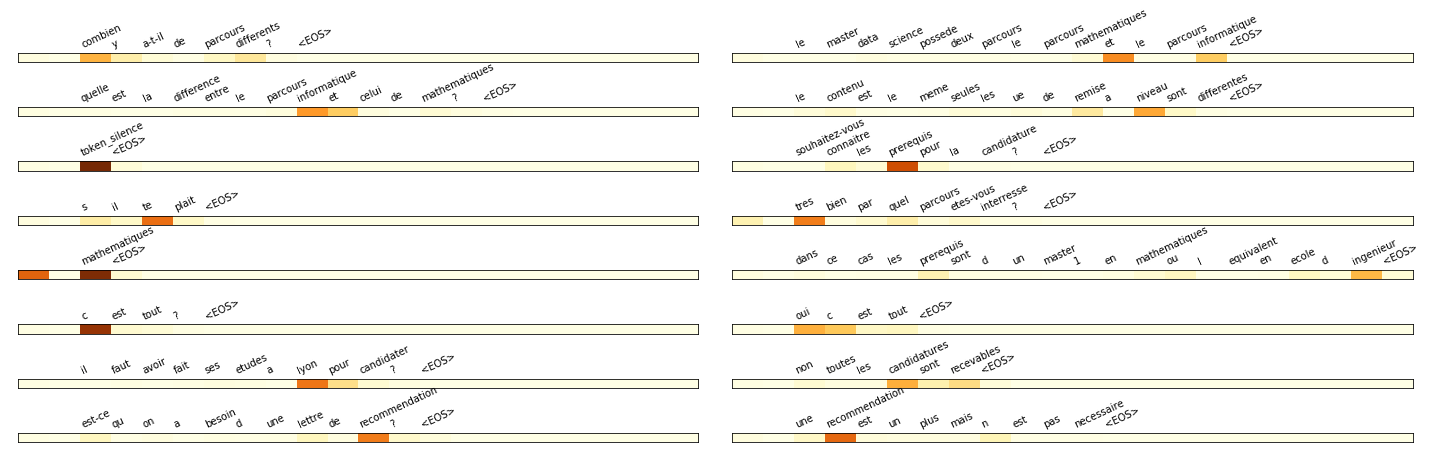

    est-ce qu il y a des options a suivre en master 1 ? 
 =  vous devriez poser la question au responsable du master data science mathematiques 
 <  vous devriez poser la question au responsable du master data science mathematiques EOS


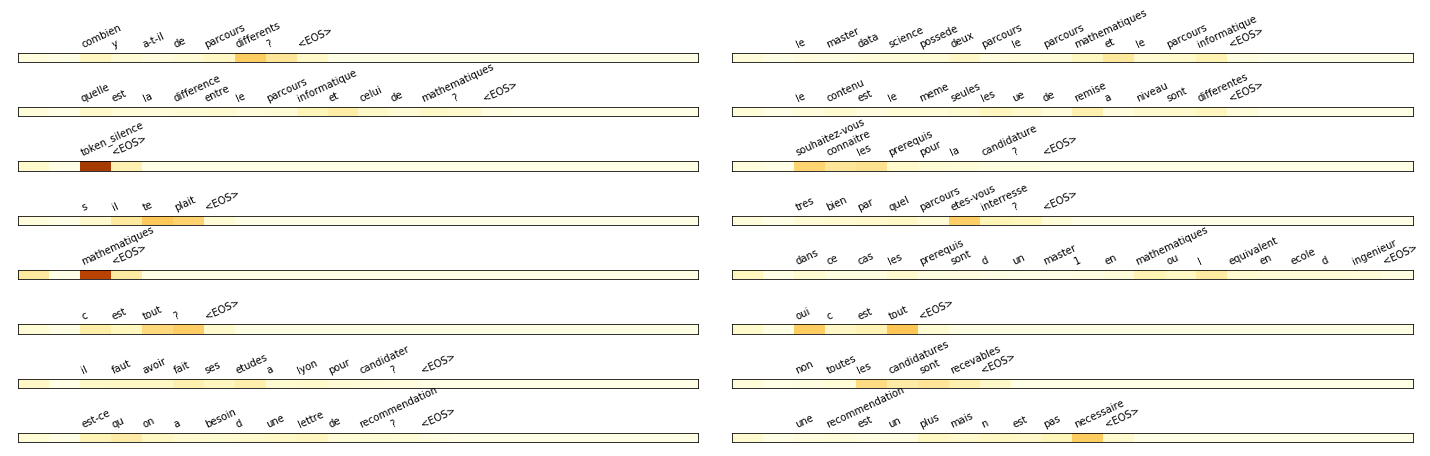

    est-ce qu il y a des options a suivre en master 1 ? 
 =  vous devriez poser la question au responsable du master data science mathematiques 
 <  vous devriez poser la question au responsable du master data science mathematiques EOS


In [102]:
ResponseEvaluation(agent_Master, dialogues_Master_test[14][:9] , HistoriqueMode = 'complete_ponderated', hops = 3)

ResponseEvaluation(agent_Master_add, dialogues_Master_test[14][:9] , HistoriqueMode = 'complete_ponderated', hops = 3)

### 6.4.2 Reenforced models

In [37]:
agent_Master.load_state_dict(torch.load('saves/agent_Master_renforced.pth'))

RuntimeError: Error(s) in loading state_dict for Agent_biGRU:
	Unexpected key(s) in state_dict: "tracker.attn1.W_1.weight", "tracker.attn1.W_1.bias", "tracker.attn1.W_r.weight", "tracker.attn1.W_r.bias", "tracker.attn1.U.weight", "tracker.attn1.W_2.weight", "tracker.attn1.W_2.bias", "tracker.attn1.W.weight", "tracker.attn1.W.bias", "tracker.Hencoder2.weight_ih_l0", "tracker.Hencoder2.weight_hh_l0", "tracker.Hencoder2.bias_ih_l0", "tracker.Hencoder2.bias_hh_l0", "tracker.H.weight", "tracker.attn2.W_1.weight", "tracker.attn2.W_1.bias", "tracker.attn2.W_r.weight", "tracker.attn2.W_r.bias", "tracker.attn2.U.weight", "tracker.attn2.W_2.weight", "tracker.attn2.W_2.bias", "tracker.attn2.W.weight", "tracker.attn2.W.bias". 
	While copying the parameter named "tracker.Hencoder.weight_ih_l0", whose dimensions in the model are torch.Size([450, 200]) and whose dimensions in the checkpoint are torch.Size([300, 200]).
	While copying the parameter named "tracker.Hencoder.weight_hh_l0", whose dimensions in the model are torch.Size([450, 150]) and whose dimensions in the checkpoint are torch.Size([300, 100]).
	While copying the parameter named "tracker.Hencoder.bias_ih_l0", whose dimensions in the model are torch.Size([450]) and whose dimensions in the checkpoint are torch.Size([300]).
	While copying the parameter named "tracker.Hencoder.bias_hh_l0", whose dimensions in the model are torch.Size([450]) and whose dimensions in the checkpoint are torch.Size([300]).
	While copying the parameter named "decoder.gru.weight_ih_l0", whose dimensions in the model are torch.Size([450, 400]) and whose dimensions in the checkpoint are torch.Size([600, 400]).
	While copying the parameter named "decoder.gru.weight_hh_l0", whose dimensions in the model are torch.Size([450, 150]) and whose dimensions in the checkpoint are torch.Size([600, 200]).
	While copying the parameter named "decoder.gru.bias_ih_l0", whose dimensions in the model are torch.Size([450]) and whose dimensions in the checkpoint are torch.Size([600]).
	While copying the parameter named "decoder.gru.bias_hh_l0", whose dimensions in the model are torch.Size([450]) and whose dimensions in the checkpoint are torch.Size([600]).
	While copying the parameter named "decoder.out.weight", whose dimensions in the model are torch.Size([1062, 150]) and whose dimensions in the checkpoint are torch.Size([1062, 200]).

In [42]:
agent_Master_add.load_state_dict(torch.load('saves/agent_Master_add_renforced.pth'))

distribution of errors (i-th entry gives the number of aswers containing i mistakes, starting from i = 0) :

In [93]:
# [22555, 15,  6, 6, 17, 1, 0, 17, 1, 0, 18, 5, 12, 0, 1, 0, 109, 0, 0, 2]
agent_Master.eval()
z = trainer.ErrorCount(agent_Master, dialogues_Master_test) # erreurs par réponse

The repartition of errors : [22557, 15, 10, 5, 17, 0, 0, 11, 0, 6, 23, 10, 9, 1, 0, 0, 101]


In [92]:
# [22549, 31, 9, 5, 17, 0, 0, 4, 1, 0, 11, 9, 8, 1, 0, 2, 116, 2]
agent_Master_add.eval()
z_add = trainer.ErrorCount(agent_Master_add, dialogues_Master_test) # erreurs par réponse

The repartition of errors : [22549, 31, 9, 5, 17, 0, 0, 4, 1, 0, 11, 9, 8, 1, 0, 2, 116, 2]


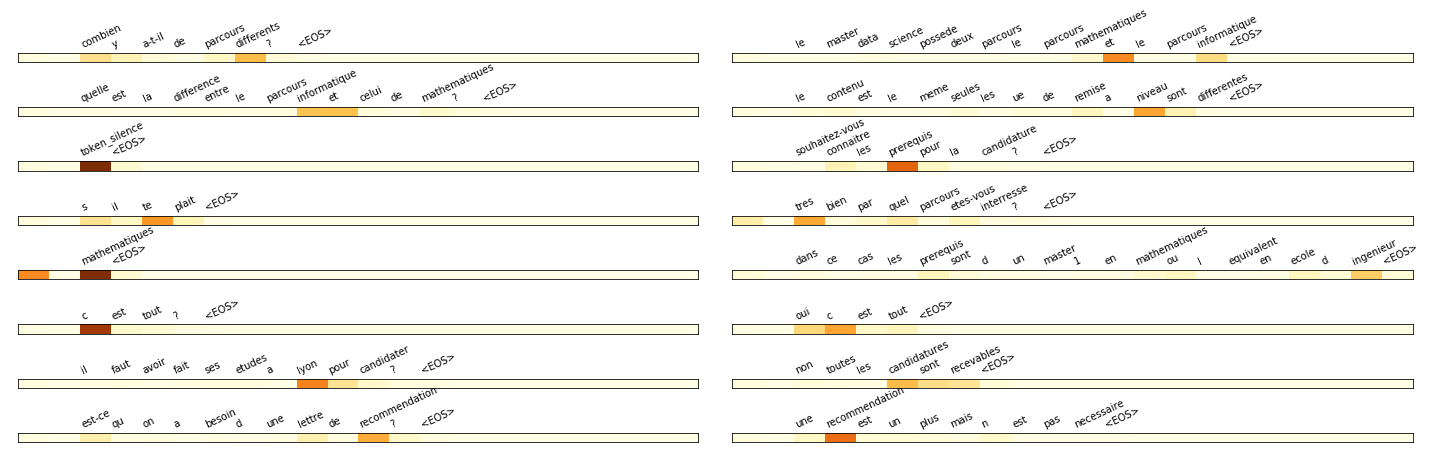

    est-ce qu il y a des options a suivre en master 1 ? 
 =  vous devriez poser la question au responsable du master data science mathematiques 
 <  vous devriez poser la question au responsable du master data science mathematiques EOS


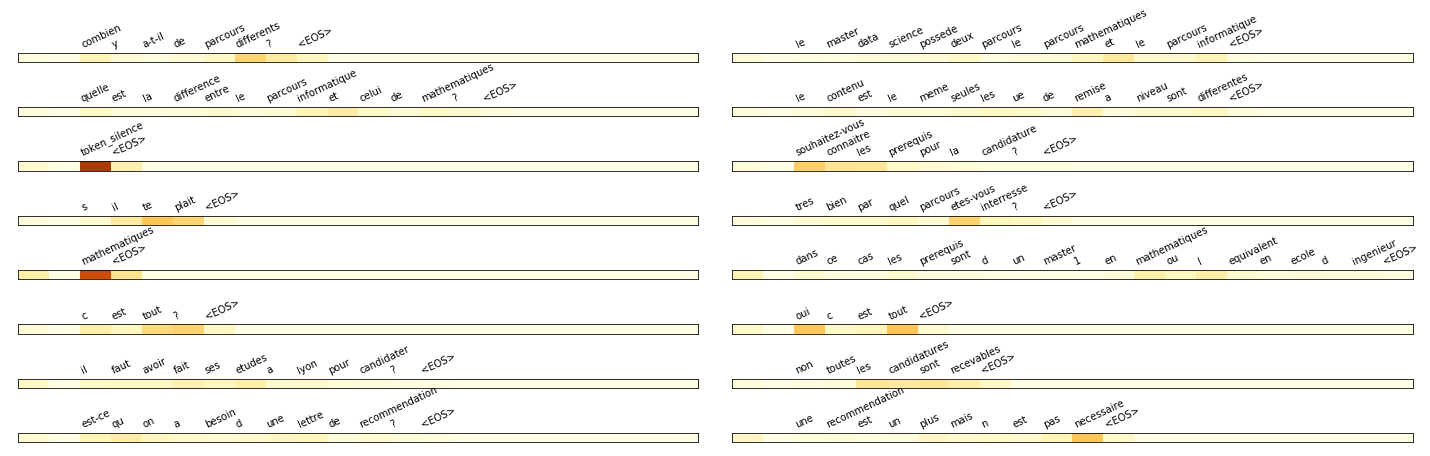

    est-ce qu il y a des options a suivre en master 1 ? 
 =  vous devriez poser la question au responsable du master data science mathematiques 
 <  vous devriez poser la question au responsable du master data science mathematiques EOS


In [104]:
ResponseEvaluation(agent_Master, dialogues_Master_test[14][:9] , HistoriqueMode = 'complete_ponderated', hops = 3)

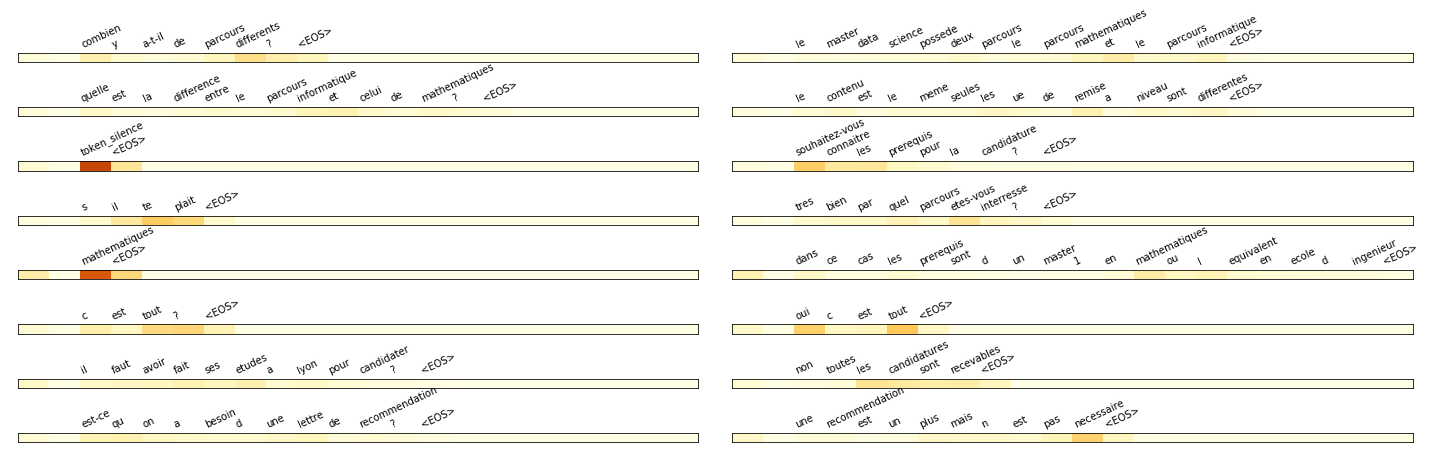

    est-ce qu il y a des options a suivre en master 1 ? 
 =  vous devriez poser la question au responsable du master data science mathematiques 
 <  vous devriez poser la question au responsable du master data science mathematiques EOS


In [39]:
ResponseEvaluation(agent_Master_add, dialogues_Master_test[14][:9] , HistoriqueMode = 'complete_ponderated', hops = 3)

**Interactive test**

write **eoc** (end of conversation) to close conversation interface :

In [37]:
agent_Master.initMemory()
InteractiveEvaluation(agent_Master)

bonjour
Bot  : bonjour EOS
comment ca va ?
Bot  : je vais bien merci et vous ? EOS
oui ca va merci
Bot  : j en suis ravi en quoi puis-je vous aider ? EOS
eoc


In [54]:
agent_Master_add.initMemory()
InteractiveEvaluation(agent_Master_add)

salut
Bot  : bonjour EOS
ca va 
Bot  : je vais bien merci et vous ? EOS
oui merci
Bot  : gardez courage en quoi puis-je vous interresse ? EOS
comment ca va 
Bot  : je m appelle Cadoc EOS
ok super
Bot  : je vous en prie EOS
est ce que tu sais marcher sur les mains ?
Bot  : c vous pouvez faire une recherche web EOS
ok je vais faire ca
Bot  : j en suis ravi en quoi puis-je vous aider ? EOS
dis moi qui est le responsable
Bot  : cela vous devez prendre contact avec la scolarite de chaque master EOS
eoc


In [39]:
agent_Master.initMemory()
InteractiveEvaluation(agent_Master)

salut
Bot  : bonjour EOS
ca va
Bot  : je suis ravi en quoi puis-je vous aider ? EOS
laisse tomber
Bot  : je vais bien merci sur une carriere EOS
eoc
